# HAT Clustering Analysis — Emotional vs Neutral (Per-Prompt Isolated)

Each data point is one permutation run — a full inference over a concatenated sequence of stories,
isolated via server reset + cache drop before each trial.

**Data layout per data point** (`runs/<label>/p<NNNN>/`):
```
perf_stat.csv        — 1ms buckets, 24 perf events (HAT Layer 1 tracepoints + Layer 2 PMU/power)
hat_interrupts.csv   — 100ms: /proc/interrupts, /proc/softirqs, CPU freq per core
proc_sample.csv      — 100ms: system + per-process CPU jiffies, RSS
collector_meta.json  — t0_ns, duration, perf_events list
trial_meta.json      — prompt_index, label, ok, t_request_start_ns, t_request_end_ns, elapsed_ms
```

**Experimental design:**
- 120 emotional permutations (5! orderings of 5 ptsd
 stories)
- 120 neutral permutations (5! orderings of 5 WikiHow articles)
- Neutral prompts are shorter on average → `elapsed_ms` used as a confounder proxy for prompt length
- Each trial is fully isolated: server reset + `drop_caches` + 2s stabilisation baseline

**Analysis approach:**
1. Extract 10 indicator metrics per HAT indicator (event-specific or PCI-specific, as appropriate)
2. Build a feature matrix: 240 rows × N metrics
3. Per-metric univariate screening (Mann-Whitney U + effect size)
4. Per-metric k=2 clustering → silhouette score → rank metrics by separability
5. Multi-metric GMM clustering on top-K features
6. Confounder check: elapsed_ms (prompt duration proxy for length difference)
7. PCoA / UMAP visualisation


In [3]:
import json, re, warnings
from pathlib import Path
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sp_stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (14, 5)

print('Imports OK')

Imports OK


## 1 — Configuration

In [4]:
# ── Set this to your mccviahat root ──
BASE_DIR = Path.home() / 'Desktop' / 'mccviahat'

NEUTRAL_ROOT   = BASE_DIR / 'runs' / 'trainingN' 
EMOTIONAL_ROOT = BASE_DIR / 'runs' / 'trainingE'

for d in [NEUTRAL_ROOT, EMOTIONAL_ROOT]:
    assert d.exists(), f'Missing run root: {d}'

n_trials = sorted(NEUTRAL_ROOT.glob('p????'))
e_trials = sorted(EMOTIONAL_ROOT.glob('p????'))

print(f'Neutral trials:   {len(n_trials)}')
print(f'Emotional trials: {len(e_trials)}')

Neutral trials:   120
Emotional trials: 120


## 2 — Loaders

Each data point is a directory. We load:
- `perf_stat.csv` (wide format, 1ms resolution) — event-indicators + PCIs from perf
- `hat_interrupts.csv` (100ms) — cumulative /proc/interrupts counters, converted to deltas
- `trial_meta.json` — elapsed_ms (used as confounder for prompt length)

In [5]:
def load_trial_meta(trial_dir: Path) -> dict:
    p = trial_dir / 'trial_meta.json'
    return json.loads(p.read_text()) if p.exists() else {}


def load_collector_meta(trial_dir: Path) -> dict:
    p = trial_dir / 'collector_meta.json'
    return json.loads(p.read_text()) if p.exists() else {}


def load_perf(trial_dir: Path) -> pd.DataFrame | None:
    """Load perf_stat.csv (wide: t_s, event1, ...). Falls back to parsing perf_stat.txt."""
    csv_p = trial_dir / 'perf_stat.csv'
    txt_p = trial_dir / 'perf_stat.txt'
    if csv_p.exists() and csv_p.stat().st_size > 0:
        return pd.read_csv(csv_p)
    if txt_p.exists() and txt_p.stat().st_size > 0:
        return _parse_perf_txt(txt_p)
    return None


def _parse_perf_txt(path: Path) -> pd.DataFrame:
    """Parse perf stat -x ',' output into wide DataFrame."""
    from collections import OrderedDict
    rows_by_ts: dict = OrderedDict()
    events_seen: list = []
    for line in path.read_text(encoding='utf-8', errors='replace').splitlines():
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split(',')
        if len(parts) < 4:
            continue
        try:
            ts = float(parts[0])
        except ValueError:
            continue
        event = parts[3].strip()
        if not event:
            continue
        val_s = parts[1].strip()
        val = float('nan') if (val_s.startswith('<') or val_s == '') else float(val_s) if val_s.replace('.','',1).isdigit() else float('nan')
        if event not in events_seen:
            events_seen.append(event)
        rows_by_ts.setdefault(ts, {})[event] = val
    records = [{'t_s': ts, **evts} for ts, evts in rows_by_ts.items()]
    df = pd.DataFrame(records).sort_values('t_s').reset_index(drop=True)
    return df


def load_hat_interrupts(trial_dir: Path) -> pd.DataFrame | None:
    """Load hat_interrupts.csv with cumulative counters converted to per-sample deltas."""
    p = trial_dir / 'hat_interrupts.csv'
    if not p.exists() or p.stat().st_size == 0:
        return None
    df = pd.read_csv(p)
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    # Convert cumulative /proc/interrupts counts to deltas (rate per sample)
    irq_cols = [c for c in df.columns
                if c not in ('timestamp_ns', 't_s')
                and not c.endswith('_freq_khz')
                and pd.api.types.is_numeric_dtype(df[c])]
    for c in irq_cols:
        df[c] = df[c].diff().clip(lower=0)  # deltas; first row becomes NaN → drop later
    df = df.iloc[1:].reset_index(drop=True)  # drop first NaN row
    return df


print('Loaders defined')

Loaders defined


## 3 — Metric definitions

We compute **10 metrics** per indicator, split by indicator type:

| # | Metric | Applies to | Description |
|---|--------|------------|-------------|
| 1 | `mean_rate` | both | Mean count/value per time unit |
| 2 | `variance` | both (PCIs esp.) | Spread around the mean |
| 3 | `p90_p10` | both | Robust range (P90 − P10) |
| 4 | `slope` | PCIs esp. | Linear trend (drift during inference) |
| 5 | `spectral_entropy` | PCIs esp. | PSD entropy — structured vs broadband |
| 6 | `iat_cv` | event-indicators | Coefficient of variation of inter-arrival times |
| 7 | `burst_rate` | event-indicators | Bursts (runs > mean+1σ) per second |
| 8 | `burst_clustering` | event-indicators | Fraction of events inside bursts |
| 9 | `lz_complexity` | both | Lempel-Ziv complexity (binarised) |
| 10 | `perm_entropy` | both | Normalised permutation entropy (order=3) |

**Neutral prompts are shorter** → elapsed_ms differs systematically. We record it as a confounder
and use it to check that any detected separation is not purely a length artifact.

In [6]:
# ─── Metric helpers ───────────────────────────────────────────────────────────

def _safe(series: np.ndarray) -> np.ndarray:
    """Drop NaN/Inf, return float64."""
    s = np.asarray(series, dtype=float)
    return s[np.isfinite(s)]


def metric_mean_rate(s: np.ndarray, dt_s: float) -> float:
    """Mean count per second (event-indicators) or mean value (PCIs)."""
    s = _safe(s)
    return float(s.mean() / dt_s) if (len(s) > 0 and dt_s > 0) else np.nan


def metric_variance(s: np.ndarray) -> float:
    s = _safe(s)
    return float(np.var(s, ddof=1)) if len(s) > 1 else np.nan


def metric_p90_p10(s: np.ndarray) -> float:
    s = _safe(s)
    return float(np.percentile(s, 90) - np.percentile(s, 10)) if len(s) > 1 else np.nan


def metric_slope(s: np.ndarray) -> float:
    """OLS slope (value per sample)."""
    s = _safe(s)
    if len(s) < 3:
        return np.nan
    x = np.arange(len(s), dtype=float)
    return float(np.polyfit(x, s, 1)[0])


def metric_spectral_entropy(s: np.ndarray) -> float:
    """Normalised Shannon entropy of power spectral density."""
    s = _safe(s)
    if len(s) < 4:
        return np.nan
    psd = np.abs(np.fft.rfft(s - s.mean())) ** 2
    psd = psd[1:]  # skip DC
    if psd.sum() == 0:
        return 0.0
    p = psd / psd.sum()
    h = -np.sum(p * np.log2(p + 1e-15))
    return float(h / np.log2(len(p))) if len(p) > 1 else 0.0


def metric_iat_cv(s: np.ndarray) -> float:
    """CV of inter-arrival times (only meaningful for event-indicators)."""
    s = _safe(s)
    arrivals = np.where(s > 0)[0]
    if len(arrivals) < 3:
        return np.nan
    iat = np.diff(arrivals).astype(float)
    mu = iat.mean()
    return float(iat.std(ddof=1) / mu) if mu > 0 else np.nan


def metric_burst_rate(s: np.ndarray, dur_s: float) -> float:
    """Bursts (contiguous runs above mean+1σ) per second."""
    s = _safe(s)
    if len(s) < 2 or s.std() == 0:
        return 0.0
    thresh = s.mean() + s.std()
    above = (s > thresh).astype(int)
    diff = np.diff(np.concatenate(([0], above, [0])))
    n_bursts = int((diff == 1).sum())
    return float(n_bursts / dur_s) if dur_s > 0 else 0.0


def metric_burst_clustering(s: np.ndarray) -> float:
    """Fraction of total events that fall inside bursts."""
    s = _safe(s)
    if len(s) < 2 or s.std() == 0 or s.sum() == 0:
        return 0.0
    thresh = s.mean() + s.std()
    above = (s > thresh).astype(int)
    diff = np.diff(np.concatenate(([0], above, [0])))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    if len(starts) == 0:
        return 0.0
    events_in_bursts = sum(s[st:en].sum() for st, en in zip(starts, ends))
    return float(events_in_bursts / s.sum())


def metric_lz_complexity(s: np.ndarray) -> float:
    """LZ76 complexity of binarised (> median) series, normalised."""
    s = _safe(s)
    if len(s) < 4:
        return np.nan
    binary = (s > np.median(s)).astype(int)
    seq = ''.join(map(str, binary))
    n = len(seq)
    i, k, l, c = 0, 1, 1, 1
    while k + l <= n:
        if seq[i + l - 1] == seq[k + l - 1]:
            l += 1
        else:
            i += 1
            if i == k:
                c += 1; k += l; i = 0; l = 1
            else:
                l = 1
    c += 1
    return float(c / (n / np.log2(n))) if n > 1 else 0.0


def metric_perm_entropy(s: np.ndarray, order: int = 3) -> float:
    """Normalised permutation entropy."""
    import math
    s = _safe(s)
    if len(s) < order:
        return np.nan
    counts = defaultdict(int)
    for i in range(len(s) - order + 1):
        counts[tuple(np.argsort(s[i:i+order]))] += 1
    total = sum(counts.values())
    probs = np.array(list(counts.values())) / total
    h = -np.sum(probs * np.log2(probs + 1e-15))
    h_max = np.log2(math.factorial(order))
    return float(h / h_max) if h_max > 0 else 0.0


def compute_all_metrics(s: np.ndarray, dur_s: float, indicator_type: str = 'event') -> dict:
    """
    Compute all 10 metrics for one indicator series.
    indicator_type: 'event' (discrete, irregular) or 'pci' (periodic, continuous).
    Both types get all 10 metrics; IAT-based ones return NaN for PCIs (constant interval).
    """
    return {
        'mean_rate':        metric_mean_rate(s, dur_s),
        'variance':         metric_variance(s),
        'p90_p10':          metric_p90_p10(s),
        'slope':            metric_slope(s),
        'spectral_entropy': metric_spectral_entropy(s),
        'iat_cv':           metric_iat_cv(s) if indicator_type == 'event' else np.nan,
        'burst_rate':       metric_burst_rate(s, dur_s),
        'burst_clustering': metric_burst_clustering(s),
        'lz_complexity':    metric_lz_complexity(s),
        'perm_entropy':     metric_perm_entropy(s),
    }


print('Metric functions defined')

Metric functions defined


## 4 — Feature extraction

Loop over all trials, load their perf and HAT interrupt data, compute metrics for each indicator.
One row = one trial = one data point.

In [7]:
# Classify perf events by indicator type
EVENT_INDICATORS = {
    'irq:irq_handler_entry', 'irq:irq_handler_exit',
    'irq:softirq_entry', 'irq:softirq_exit', 'irq:softirq_raise',
    'tlb:tlb_flush', 'mce:mce_record',
    'context-switches', 'cpu-migrations', 'page-faults',
}
# Everything else in perf is a PCI (counter read at fixed 1ms intervals)


def extract_trial_features(trial_dir: Path, label: str) -> dict | None:
    """Return a flat feature dict for one trial directory, or None on failure."""
    t_meta = load_trial_meta(trial_dir)
    if not t_meta.get('ok', False):
        return None  # failed trial

    perf = load_perf(trial_dir)
    if perf is None or len(perf) < 10:
        return None  # collector didn't produce usable data

    c_meta = load_collector_meta(trial_dir)
    dur_s = t_meta.get('elapsed_ms', np.nan) / 1000.0

    row = {
        'condition':   label,
        'prompt_index': t_meta.get('prompt_index', -1),
        'elapsed_ms':  t_meta.get('elapsed_ms', np.nan),
        'dur_s':       dur_s,
    }

    # ── perf indicators ──
    perf_events = [c for c in perf.columns if c != 't_s']
    for evt in perf_events:
        s = perf[evt].values.astype(float)
        itype = 'event' if evt in EVENT_INDICATORS else 'pci'
        metrics = compute_all_metrics(s, dur_s, itype)
        for m_name, m_val in metrics.items():
            row[f'{evt}__{m_name}'] = m_val

    # ── HAT interrupt indicators (delta counts at 100ms) ──
    hat = load_hat_interrupts(trial_dir)
    if hat is not None:
        hat_irq_cols = [
        c for c in hat.columns
        if c not in ('timestamp_ns', 't_s')
        and not c.endswith('_freq_khz')
        and pd.api.types.is_numeric_dtype(hat[c])
        and not c.isdigit()  # Exclude numeric IRQs
        and not (c.startswith('hat_') and c[4:].isdigit())  # Exclude hat_### IRQs
        ]
        hat_freq_cols = [c for c in hat.columns if c.endswith('_freq_khz')]

        for col in hat_irq_cols:
            s = hat[col].values.astype(float)
            metrics = compute_all_metrics(s, dur_s, 'event')
            for m_name, m_val in metrics.items():
                row[f'hat_{col}__{m_name}'] = m_val

        # CPU frequency: PCI at 100ms — mean and variance per trial
        if hat_freq_cols:
            freq_mean = hat[hat_freq_cols].mean(axis=1).values
            metrics = compute_all_metrics(freq_mean, dur_s, 'pci')
            for m_name, m_val in metrics.items():
                row[f'cpu_freq_mean__{m_name}'] = m_val

    return row


# ── Run extraction ──
print('Extracting features…')
records = []
skipped = 0

for trial_dir in n_trials:
    r = extract_trial_features(trial_dir, 'neutral')
    if r is not None:
        records.append(r)
    else:
        skipped += 1

for trial_dir in e_trials:
    r = extract_trial_features(trial_dir, 'emotional')
    if r is not None:
        records.append(r)
    else:
        skipped += 1

df_all = pd.DataFrame(records)
print(f'Loaded: {len(df_all)} trials ({skipped} skipped)')
print(f'  neutral:   {(df_all.condition == "neutral").sum()}')
print(f'  emotional: {(df_all.condition == "emotional").sum()}')
print(f'Feature columns: {len(df_all.columns) - 4}')

Extracting features…
Loaded: 240 trials (0 skipped)
  neutral:   120
  emotional: 120
Feature columns: 540
Loaded: 240 trials (0 skipped)
  neutral:   120
  emotional: 120
Feature columns: 540


## 5 — Confounder check: elapsed_ms

Neutral prompts are shorter. If elapsed_ms differs significantly between conditions,
any metric that scales with prompt duration is a confounder, not a true signal.
We check this explicitly and will flag length-sensitive metrics.

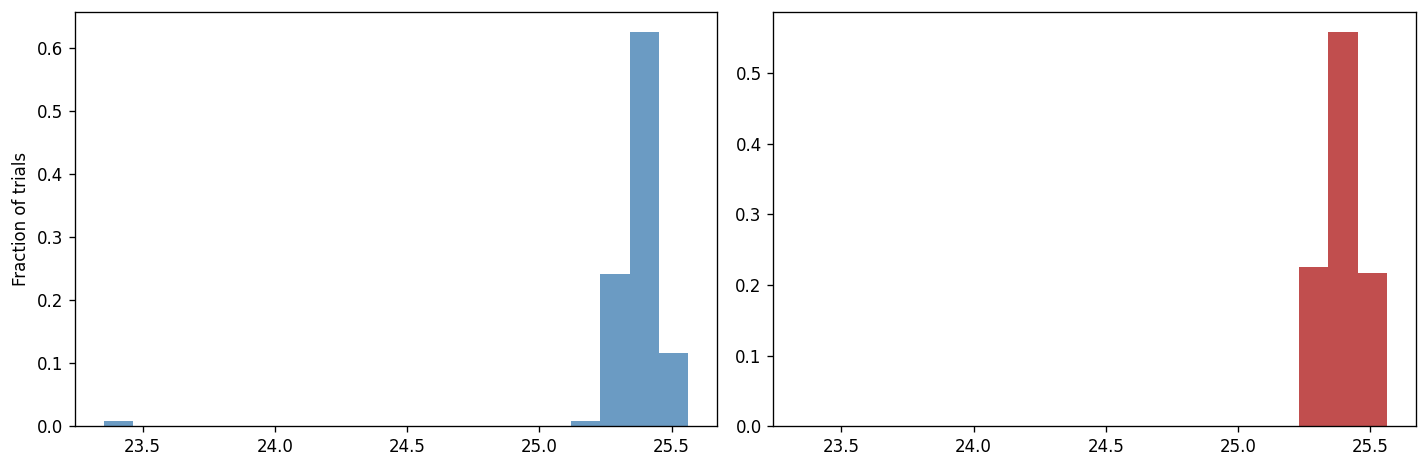


Length confound flag: False
Note: mean_rate is normalised by dur_s, so it is NOT confounded by length.
Metrics like burst_rate (per-second) are also duration-normalised.
Metrics like variance, p90_p10, lz_complexity may scale with duration → flag if sig.


In [141]:
weights_n = np.ones(len(dur_n)) / len(dur_n)
weights_e = np.ones(len(dur_e)) / len(dur_e)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].hist(dur_n, bins=bins, weights=weights_n, color='steelblue', alpha=0.8)
axes[1].hist(dur_e, bins=bins, weights=weights_e, color='firebrick', alpha=0.8)

axes[0].set_ylabel('Fraction of trials')
plt.tight_layout()
plt.show()

LENGTH_CONFOUNDED = p_len < 0.05
print(f'\nLength confound flag: {LENGTH_CONFOUNDED}')
print('Note: mean_rate is normalised by dur_s, so it is NOT confounded by length.')
print('Metrics like burst_rate (per-second) are also duration-normalised.')
print('Metrics like variance, p90_p10, lz_complexity may scale with duration → flag if sig.')

In [106]:
# --- Feature selection: include/exclude length-confounded features ---
from typing import List

# List of metrics that may be length-confounded
'''LENGTH_CONFOUNDED_METRICS = {
    'variance', 'p90_p10', 'lz_complexity', 'perm_entropy', 'spectral_entropy'
}'''
LENGTH_CONFOUNDED_METRICS = {
     'p90_p10', 'perm_entropy'
}
feature_cols = [c for c in df_all.columns if '__' in c]

def metric_of(col: str) -> str:
    # evt__metric
    return col.split('__', 1)[1]

length_confounded_cols   = [c for c in feature_cols if metric_of(c) in LENGTH_CONFOUNDED_METRICS]
length_unconfounded_cols = [c for c in feature_cols if metric_of(c) not in LENGTH_CONFOUNDED_METRICS]

print(f"Length-confounded features: {len(length_confounded_cols)}")
print(f"Length-unconfounded features: {len(length_unconfounded_cols)}")

# User selection: set to True to include, False to exclude length-confounded features
INCLUDE_LENGTH_CONFOUNDED = False  # <-- change this to True to include them

if INCLUDE_LENGTH_CONFOUNDED:
    selected_cols = length_unconfounded_cols + length_confounded_cols
    print("Including ALL features (length-confounded and unconfounded).")
else:
    selected_cols = length_unconfounded_cols
    print("Excluding length-confounded features.")

# Subset the feature matrix for downstream analysis
X = df_all[selected_cols].copy()
print(f"Final feature matrix shape: {X.shape}")

Length-confounded features: 108
Length-unconfounded features: 432
Excluding length-confounded features.
Final feature matrix shape: (240, 432)


In [107]:
# --- Regress out token_count and elapsed_ms from all features ---
import re
from sklearn.linear_model import LinearRegression
import numpy as np

# You provided per-class token counts — set them explicitly
token_count_neutral = 2155
token_count_emotional = 2166

# Assign token_count per trial (do not overwrite existing column if present)
if 'token_count' not in df_all.columns:
    df_all['token_count'] = 0
    df_all.loc[df_all.condition == 'neutral', 'token_count'] = token_count_neutral
    df_all.loc[df_all.condition == 'emotional', 'token_count'] = token_count_emotional
else:
    # ensure numeric and fill missing per-class values if any
    df_all['token_count'] = pd.to_numeric(df_all['token_count'], errors='coerce').fillna(0).astype(int)

print(f'Using token_count: neutral={token_count_neutral}, emotional={token_count_emotional}')

# Regress out token_count and elapsed_ms from all feature columns
feature_cols = [c for c in df_all.columns if '__' in c]
for col in feature_cols:
    y_feat = df_all[col].values
    X_reg = df_all[['token_count', 'elapsed_ms']].values
    mask = np.isfinite(y_feat) & np.all(np.isfinite(X_reg), axis=1)
    if mask.sum() < 10:
        continue
    reg = LinearRegression()
    reg.fit(X_reg[mask], y_feat[mask])
    y_pred = reg.predict(X_reg)
    df_all[col] = y_feat - y_pred  # Replace with residuals

print("Regressed out token_count and elapsed_ms from all features.")

Using token_count: neutral=2155, emotional=2166
Regressed out token_count and elapsed_ms from all features.


## 6 — Build feature matrix and clean

In [108]:
# --- Build feature matrix and clean ---
# Use selected_cols from previous cell (already filtered for confounding)

META_COLS = {'condition', 'prompt_index', 'elapsed_ms', 'dur_s'}
feat_cols = [c for c in X.columns if c not in META_COLS]

X_raw = X[feat_cols].copy()
y = (df_all['condition'] == 'emotional').astype(int).values  # 0=neutral, 1=emotional

# Drop zero-variance columns and fill NaN
X_raw = X_raw.loc[:, X_raw.std() > 0]
X_raw = X_raw.fillna(X_raw.median())

feat_cols = list(X_raw.columns)
print(f'Feature matrix: {X_raw.shape[0]} samples × {X_raw.shape[1]} features')

# Standardise
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=feat_cols)
print('Standardised.')

Feature matrix: 240 samples × 280 features
Standardised.


In [109]:
# --- Diagnostics: Check feature selection logic ---
print(f"INCLUDE_LENGTH_CONFOUNDED = {INCLUDE_LENGTH_CONFOUNDED}")
print(f"Length-confounded features matched: {len(length_confounded_cols)}")
print(f"Length-unconfounded features matched: {len(length_unconfounded_cols)}")
print(f"Selected columns: {len(selected_cols)}")
print(f"First 10 selected columns: {selected_cols[:10]}")
print(f"Final feature matrix shape after cleaning: {X.shape}")

INCLUDE_LENGTH_CONFOUNDED = False
Length-confounded features matched: 108
Length-unconfounded features matched: 432
Selected columns: 432
First 10 selected columns: ['irq:irq_handler_entry__mean_rate', 'irq:irq_handler_entry__variance', 'irq:irq_handler_entry__slope', 'irq:irq_handler_entry__spectral_entropy', 'irq:irq_handler_entry__iat_cv', 'irq:irq_handler_entry__burst_rate', 'irq:irq_handler_entry__burst_clustering', 'irq:irq_handler_entry__lz_complexity', 'irq:irq_handler_exit__mean_rate', 'irq:irq_handler_exit__variance']
Final feature matrix shape after cleaning: (240, 280)


## 7 — Univariate screening: Mann-Whitney U per metric

Non-parametric test for each feature. We report effect size (rank-biserial r) and direction.

In [110]:
results = []
n_vals = X_raw[y == 0]
e_vals = X_raw[y == 1]

for col in feat_cols:
    nv = n_vals[col].dropna().values
    ev = e_vals[col].dropna().values
    if len(nv) < 5 or len(ev) < 5:
        continue
    if nv.std() == 0 and ev.std() == 0:
        continue
    stat, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
    r = 1 - (2 * stat) / (len(nv) * len(ev))  # rank-biserial r
    results.append({
        'feature':   col,
        'U':         stat,
        'p':         p,
        'effect_r':  r,
        'n_mean':    nv.mean(),
        'e_mean':    ev.mean(),
        'direction': '↑E' if ev.mean() > nv.mean() else '↓E',
    })

mwu_df = pd.DataFrame(results).sort_values('p').reset_index(drop=True)

# Bonferroni-corrected threshold
alpha_raw = 0.05
alpha_bonf = alpha_raw / len(mwu_df)
sig_strict = mwu_df[mwu_df.p < alpha_bonf]
sig_nominal = mwu_df[mwu_df.p < alpha_raw]

print(f'Features tested: {len(mwu_df)}')
print(f'Significant at p<{alpha_raw} (nominal):    {len(sig_nominal)}')
print(f'Significant at p<{alpha_bonf:.2e} (Bonferroni): {len(sig_strict)}')
print()
print('=== Top 30 features by p-value ===')
print(mwu_df.head(30)[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
    index=False, float_format='{:.4f}'.format))

Features tested: 280
Significant at p<0.05 (nominal):    97
Significant at p<1.79e-04 (Bonferroni): 36

=== Top 30 features by p-value ===
                             feature          U      p  effect_r direction
              page-faults__mean_rate 12898.0000 0.0000   -0.7914        ↓E
             page-faults__burst_rate 12531.0000 0.0000   -0.7404        ↓E
          page-faults__lz_complexity 12509.0000 0.0000   -0.7374        ↓E
               page-faults__variance 12432.0000 0.0000   -0.7267        ↓E
     irq:irq_handler_exit__mean_rate 12269.0000 0.0000   -0.7040        ↓E
    irq:irq_handler_entry__mean_rate 12269.0000 0.0000   -0.7040        ↓E
               hat_NET_RX__mean_rate 12246.0000 0.0000   -0.7008        ↓E
       page-faults__burst_clustering 12077.0000 0.0000   -0.6774        ↓E
      irq:irq_handler_exit__variance 11974.0000 0.0000   -0.6631        ↓E
     irq:irq_handler_entry__variance 11973.0000 0.0000   -0.6629        ↓E
    irq:irq_handler_exit__burst_rate

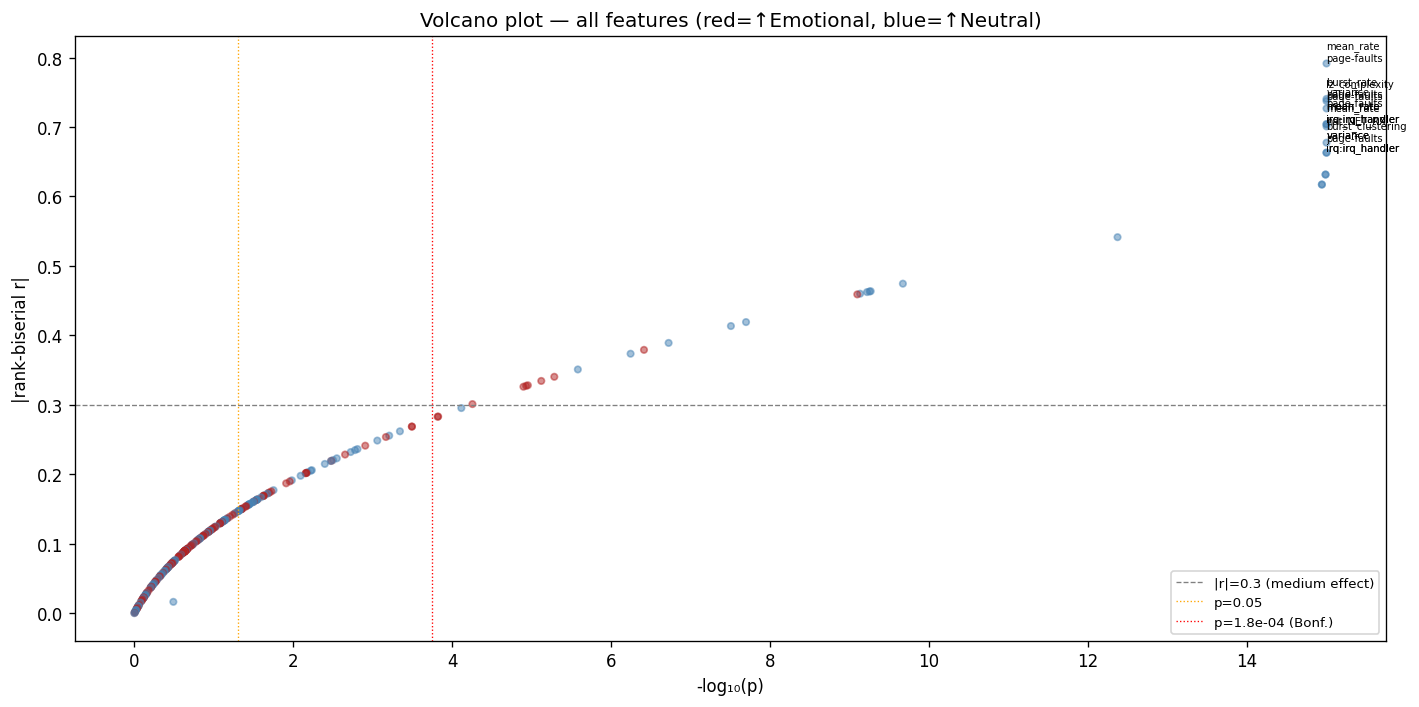

In [111]:
# Volcano plot: effect size vs -log10(p)
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['firebrick' if r > 0 else 'steelblue' for r in mwu_df.effect_r]
ax.scatter(-np.log10(mwu_df.p + 1e-15), mwu_df.effect_r.abs(),
           c=colors, alpha=0.5, s=15)
ax.axhline(0.3, ls='--', color='gray', lw=0.8, label='|r|=0.3 (medium effect)')
ax.axvline(-np.log10(alpha_raw), ls=':', color='orange', lw=0.8, label=f'p={alpha_raw}')
ax.axvline(-np.log10(alpha_bonf), ls=':', color='red', lw=0.8, label=f'p={alpha_bonf:.1e} (Bonf.)')
# Label top 10
for _, row in mwu_df.head(10).iterrows():
    ax.annotate(row.feature.split('__')[-1] + '\n' + row.feature.split('__')[0][:15],
                xy=(-np.log10(row.p + 1e-15), abs(row.effect_r)),
                fontsize=6, ha='left', va='bottom')
ax.set_xlabel('-log₁₀(p)')
ax.set_ylabel('|rank-biserial r|')
ax.set_title('Volcano plot — all features (red=↑Emotional, blue=↑Neutral)')
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_volcano.png', dpi=150, bbox_inches='tight')
plt.show()

## 8 — Per-metric k=2 clustering → silhouette ranking

For each feature independently, fit k-means with k=2 and score how well the
resulting clusters align with the ground-truth labels.

Two scores per feature:
- **Silhouette**: geometric cluster quality (−1 to 1, higher = more separated)
- **ARI** (Adjusted Rand Index): overlap with true labels (0=random, 1=perfect)

In [113]:
cluster_results = []

for col in feat_cols:
    x1d = X[[col]].values
    if np.isnan(x1d).any():
        continue
    km = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels_pred = km.fit_predict(x1d)
    sil = silhouette_score(x1d, labels_pred)
    ari = adjusted_rand_score(y, labels_pred)
    # Cluster purity: fraction of majority label in each cluster
    mask0 = labels_pred == 0
    mask1 = labels_pred == 1
    purity = max(
        (y[mask0] == 0).mean() if mask0.sum() > 0 else 0,
        (y[mask0] == 1).mean() if mask0.sum() > 0 else 0,
    ) * 0.5 + max(
        (y[mask1] == 0).mean() if mask1.sum() > 0 else 0,
        (y[mask1] == 1).mean() if mask1.sum() > 0 else 0,
    ) * 0.5
    cluster_results.append({
        'feature':   col,
        'silhouette': sil,
        'ari':       ari,
        'purity':    purity,
    })

clust_df = pd.DataFrame(cluster_results).sort_values('silhouette', ascending=False).reset_index(drop=True)
print('=== Top 30 features by silhouette score ===')
print(clust_df.head(30).to_string(index=False, float_format='{:.4f}'.format))

=== Top 30 features by silhouette score ===
                      feature  silhouette     ari  purity
    hat_MCP__burst_clustering      0.9994 -0.0010  0.5158
    hat_MCP__spectral_entropy      0.9994 -0.0010  0.5158
          hat_MCP__burst_rate      0.9992 -0.0010  0.5158
            hat_MCP__variance      0.9992 -0.0010  0.5158
           hat_MCP__mean_rate      0.9991 -0.0010  0.5158
    hat_TLB__burst_clustering      0.9953 -0.0017  0.5180
          hat_CAL__burst_rate      0.9951  0.0000  0.7510
 hat_NET_TX__burst_clustering      0.9947  0.0018  0.6565
    hat_TLB__spectral_entropy      0.9947 -0.0017  0.5180
 hat_NET_TX__spectral_entropy      0.9942  0.0018  0.6565
         hat_NET_TX__variance      0.9931  0.0000  0.7510
              hat_IWI__iat_cv      0.9907  0.0000  0.7510
            hat_NET_TX__slope      0.9879  0.0000  0.7510
       hat_NET_TX__burst_rate      0.9876  0.0018  0.6565
        hat_NET_TX__mean_rate      0.9872  0.0000  0.7510
    hat_IWI__burst_clusterin

In [114]:
# Combine MWU p-value and silhouette into one ranking table
ranking = mwu_df[['feature', 'p', 'effect_r', 'direction']].merge(
    clust_df[['feature', 'silhouette', 'ari', 'purity']], on='feature', how='inner')

# Composite score: (1 - normalised_p_rank) * 0.5 + silhouette_rank * 0.5
ranking['p_rank']   = ranking['p'].rank()
ranking['sil_rank'] = (-ranking['silhouette']).rank()  # lower is better
ranking['composite_rank'] = ranking[['p_rank', 'sil_rank']].mean(axis=1)
ranking = ranking.sort_values('composite_rank').reset_index(drop=True)

print('=== Combined ranking (MWU + silhouette) — top 30 ===')
print(ranking.head(30)[['feature','p','effect_r','direction','silhouette','ari','purity']]
      .to_string(index=False, float_format='{:.4f}'.format))

# Save full ranking
ranking.to_csv(BASE_DIR / 'metric_ranking.csv', index=False)
print(f'\nSaved → {BASE_DIR}/metric_ranking.csv')

=== Combined ranking (MWU + silhouette) — top 30 ===
                                  feature      p  effect_r direction  silhouette     ari  purity
                    page-faults__variance 0.0000   -0.7267        ↓E      0.9702  0.0001  0.7521
          irq:irq_handler_entry__variance 0.0000   -0.6629        ↓E      0.9648  0.0004  0.7532
           irq:irq_handler_exit__variance 0.0000   -0.6631        ↓E      0.9648  0.0004  0.7532
                   page-faults__mean_rate 0.0000   -0.7914        ↓E      0.8986  0.0001  0.7521
                     hat_NET_RX__variance 0.0000   -0.3736        ↓E      0.9617  0.0008  0.7542
              irq:softirq_entry__variance 0.0000   -0.4636        ↓E      0.8844  0.0001  0.7521
            page-faults__burst_clustering 0.0000   -0.6774        ↓E      0.7041  0.2389  0.7717
               irq:softirq_exit__variance 0.0000   -0.4632        ↓E      0.8842  0.0001  0.7521
              irq:softirq_raise__variance 0.0000   -0.4624        ↓E      

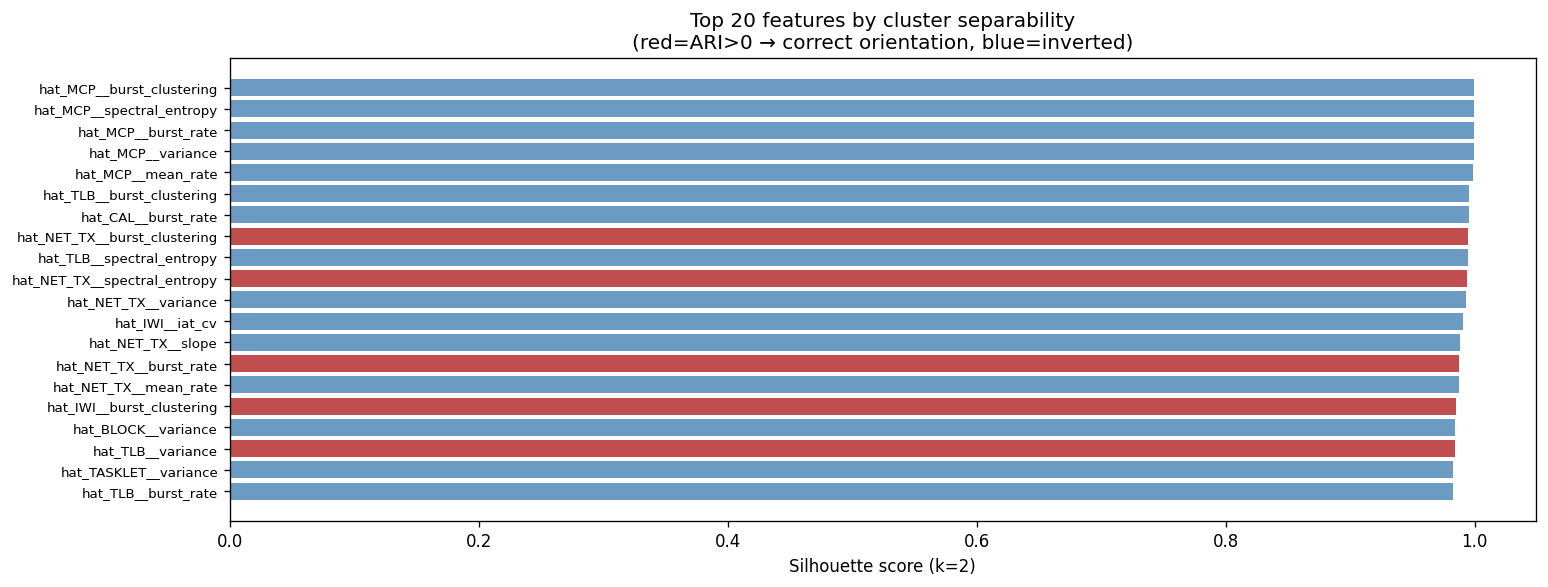

In [115]:
# Bar chart: top 20 features by silhouette
top20 = clust_df.head(20)
fig, ax = plt.subplots(figsize=(13, 5))
colors = ['firebrick' if row.ari > 0 else 'steelblue'
          for _, row in top20.iterrows()]
ax.barh(range(len(top20)), top20.silhouette, color=colors, alpha=0.8)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20.feature, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Silhouette score (k=2)')
ax.set_title('Top 20 features by cluster separability\n(red=ARI>0 → correct orientation, blue=inverted)')
ax.axvline(0, color='black', lw=0.5)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_silhouette_ranking.png', dpi=150, bbox_inches='tight')
plt.show()

## 9 — Per-indicator metric summary

Which metric type (mean_rate, variance, burst_clustering, …) drives the most separable features?
Aggregate silhouette scores by metric suffix.

=== Metric type summary ===
          metric  n_features  mean_sil  max_sil  mean_ari              best_feature
        variance          37    0.7083   0.9992    0.0089         hat_MCP__variance
spectral_entropy          37    0.6521   0.9994    0.0082 hat_MCP__spectral_entropy
      burst_rate          37    0.6483   0.9992    0.0328       hat_MCP__burst_rate
       mean_rate          37    0.6477   0.9991    0.0291        hat_MCP__mean_rate
burst_clustering          35    0.6476   0.9994    0.0156 hat_MCP__burst_clustering
           slope          37    0.6155   0.9879    0.0081         hat_NET_TX__slope
          iat_cv           8    0.6089   0.9907    0.0212           hat_IWI__iat_cv
   lz_complexity          52    0.6069   0.9757    0.0171 hat_NET_TX__lz_complexity


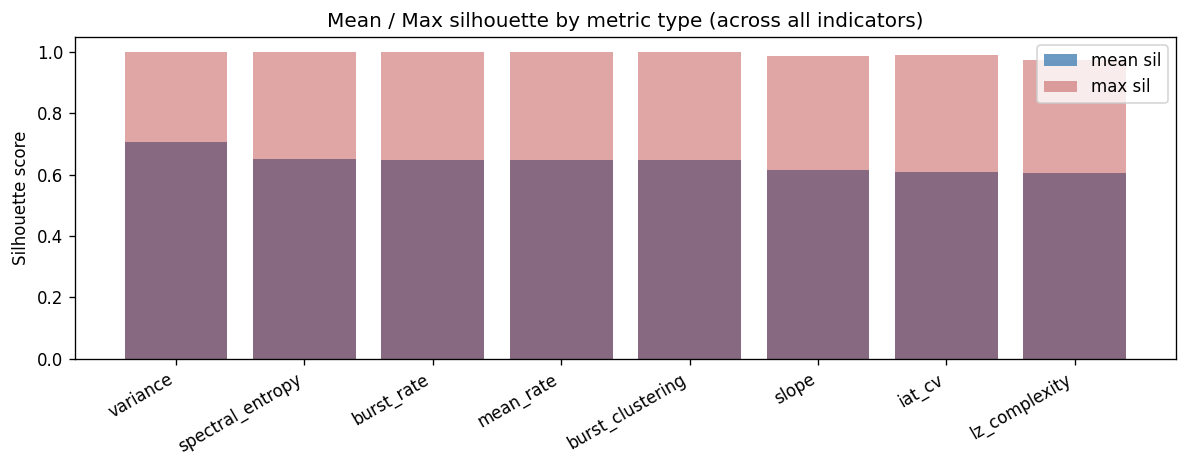

In [116]:
METRIC_NAMES = ['mean_rate','variance','p90_p10','slope','spectral_entropy',
                'iat_cv','burst_rate','burst_clustering','lz_complexity','perm_entropy']

metric_agg = []
for m in METRIC_NAMES:
    rows = clust_df[clust_df.feature.str.endswith(f'__{m}')]
    if len(rows) == 0:
        continue
    metric_agg.append({
        'metric':       m,
        'n_features':   len(rows),
        'mean_sil':     rows.silhouette.mean(),
        'max_sil':      rows.silhouette.max(),
        'mean_ari':     rows.ari.mean(),
        'best_feature': rows.iloc[0].feature,
    })

metric_agg_df = pd.DataFrame(metric_agg).sort_values('mean_sil', ascending=False)
print('=== Metric type summary ===')
print(metric_agg_df.to_string(index=False, float_format='{:.4f}'.format))

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(metric_agg_df.metric, metric_agg_df.mean_sil, alpha=0.8, color='steelblue', label='mean sil')
ax.bar(metric_agg_df.metric, metric_agg_df.max_sil, alpha=0.4, color='firebrick', label='max sil')
ax.set_ylabel('Silhouette score')
ax.set_title('Mean / Max silhouette by metric type (across all indicators)')
ax.legend()
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_metric_type_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 10 — GMM clustering on top-K features

Select the top K features by composite rank, fit a 2-component GMM, and evaluate
cluster assignment against ground-truth labels.

In [143]:
TOP_K = 7 # adjust after inspecting ranking

top_features = ranking.head(TOP_K)['feature'].tolist()
X_top = X[top_features].values

# GMM with k=2
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=10)
gmm.fit(X_top)
gmm_labels = gmm.predict(X_top)
gmm_probs  = gmm.predict_proba(X_top)

ari_gmm  = adjusted_rand_score(y, gmm_labels)
sil_gmm  = silhouette_score(X_top, gmm_labels)

# Align GMM label 0/1 to neutral/emotional
# (GMM labels are arbitrary — check which assignment gives better accuracy)
acc_direct  = (gmm_labels == y).mean()
acc_flipped = (1 - gmm_labels == y).mean()
if acc_flipped > acc_direct:
    gmm_labels = 1 - gmm_labels
    gmm_probs  = gmm_probs[:, ::-1]
accuracy = (gmm_labels == y).mean()

print(f'GMM (k=2) on top {TOP_K} features:')
print(f'  ARI:      {ari_gmm:.4f}')
print(f'  Silhouette: {sil_gmm:.4f}')
print(f'  Accuracy vs ground truth: {accuracy:.1%}')
print(f'  Neutral correctly assigned:   {(gmm_labels[y==0] == 0).mean():.1%}')
print(f'  Emotional correctly assigned: {(gmm_labels[y==1] == 1).mean():.1%}')

GMM (k=2) on top 7 features:
  ARI:      0.4093
  Silhouette: 0.3650
  Accuracy vs ground truth: 82.1%
  Neutral correctly assigned:   89.2%
  Emotional correctly assigned: 75.0%


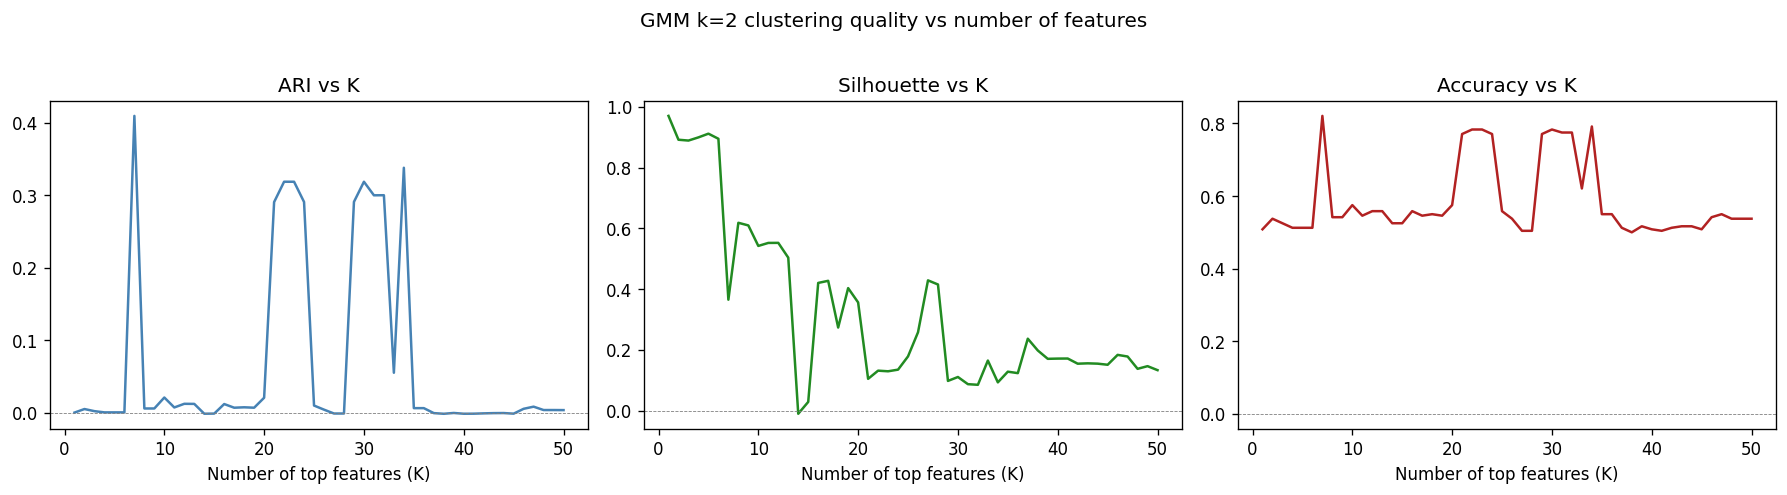

In [118]:
# Sweep K from 1 to 50: how does clustering quality scale with number of features?
K_vals = list(range(1, min(51, len(feat_cols) + 1)))
ari_vals, sil_vals, acc_vals = [], [], []

for k in K_vals:
    feats = ranking.head(k)['feature'].tolist()
    Xk = X[feats].values
    try:
        gmm_k = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=5)
        lbl = gmm_k.fit_predict(Xk)
        ari_k = adjusted_rand_score(y, lbl)
        sil_k = silhouette_score(Xk, lbl) if len(np.unique(lbl)) > 1 else 0.0
        acc_k = max((lbl == y).mean(), (1 - lbl == y).mean())
        ari_vals.append(ari_k); sil_vals.append(sil_k); acc_vals.append(acc_k)
    except Exception:
        ari_vals.append(np.nan); sil_vals.append(np.nan); acc_vals.append(np.nan)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, vals, title, color in [
    (axes[0], ari_vals,  'ARI vs K',        'steelblue'),
    (axes[1], sil_vals,  'Silhouette vs K', 'forestgreen'),
    (axes[2], acc_vals,  'Accuracy vs K',   'firebrick'),
]:
    ax.plot(K_vals, vals, color=color, lw=1.5)
    ax.axhline(0, color='gray', lw=0.5, ls='--')
    ax.set_xlabel('Number of top features (K)')
    ax.set_title(title)

plt.suptitle('GMM k=2 clustering quality vs number of features', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_k_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

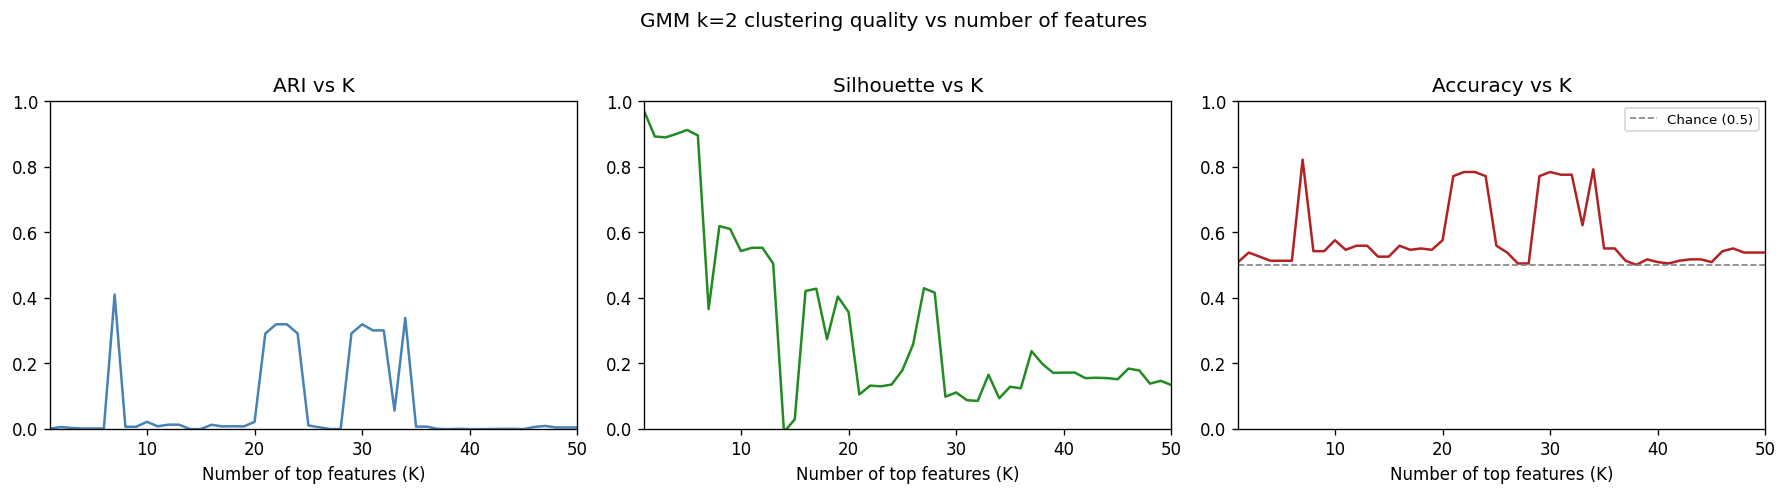

In [145]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, vals, title, color in [
    (axes[0], ari_vals,  'ARI vs K',        'steelblue'),
    (axes[1], sil_vals,  'Silhouette vs K', 'forestgreen'),
    (axes[2], acc_vals,  'Accuracy vs K',   'firebrick'),
]:
    ax.plot(K_vals, vals, color=color, lw=1.5)
    ax.set_ylim(0, 1)                     # force 0–1 range
    ax.set_xlim(min(K_vals), max(K_vals))
    ax.set_xlabel('Number of top features (K)')
    ax.set_title(title)

# Add 0.5 reference line to Accuracy panel only
axes[2].axhline(0.5, color='gray', lw=1.0, ls='--', label='Chance (0.5)')
axes[2].legend(fontsize=8)

plt.suptitle('GMM k=2 clustering quality vs number of features', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_k_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

In [144]:
import numpy as np
import pandas as pd

k_df = pd.DataFrame({
    'K': K_vals,
    'ARI': ari_vals,
    'Silhouette': sil_vals,
    'Accuracy': acc_vals
})

# Remove NaNs just in case
k_df_clean = k_df.dropna()

print('=== K-sweep summary statistics ===\n')

for metric in ['ARI', 'Silhouette', 'Accuracy']:
    vals = k_df_clean[metric].values
    ks   = k_df_clean['K'].values
    
    max_idx = np.argmax(vals)
    min_idx = np.argmin(vals)
    
    print(f'{metric}:')
    print(f'  Max = {vals[max_idx]:.4f} at K = {ks[max_idx]}')
    print(f'  Min = {vals[min_idx]:.4f} at K = {ks[min_idx]}')
    print(f'  Mean = {np.mean(vals):.4f}')
    print(f'  Std  = {np.std(vals):.4f}')
    print()

# Optional: best overall K by each metric
best_ari_k = k_df_clean.loc[k_df_clean['ARI'].idxmax(), 'K']
best_sil_k = k_df_clean.loc[k_df_clean['Silhouette'].idxmax(), 'K']
best_acc_k = k_df_clean.loc[k_df_clean['Accuracy'].idxmax(), 'K']

print('=== Best K by metric ===')
print(f'Best ARI at K = {best_ari_k}')
print(f'Best Silhouette at K = {best_sil_k}')
print(f'Best Accuracy at K = {best_acc_k}')

=== K-sweep summary statistics ===

ARI:
  Max = 0.4093 at K = 7
  Min = -0.0015 at K = 38
  Mean = 0.0679
  Std  = 0.1260

Silhouette:
  Max = 0.9702 at K = 1
  Min = -0.0107 at K = 14
  Mean = 0.3221
  Std  = 0.2672

Accuracy:
  Max = 0.8208 at K = 7
  Min = 0.5000 at K = 38
  Mean = 0.5841
  Std  = 0.1018

=== Best K by metric ===
Best ARI at K = 7
Best Silhouette at K = 1
Best Accuracy at K = 7


## 11 — PCA visualisation of cluster structure

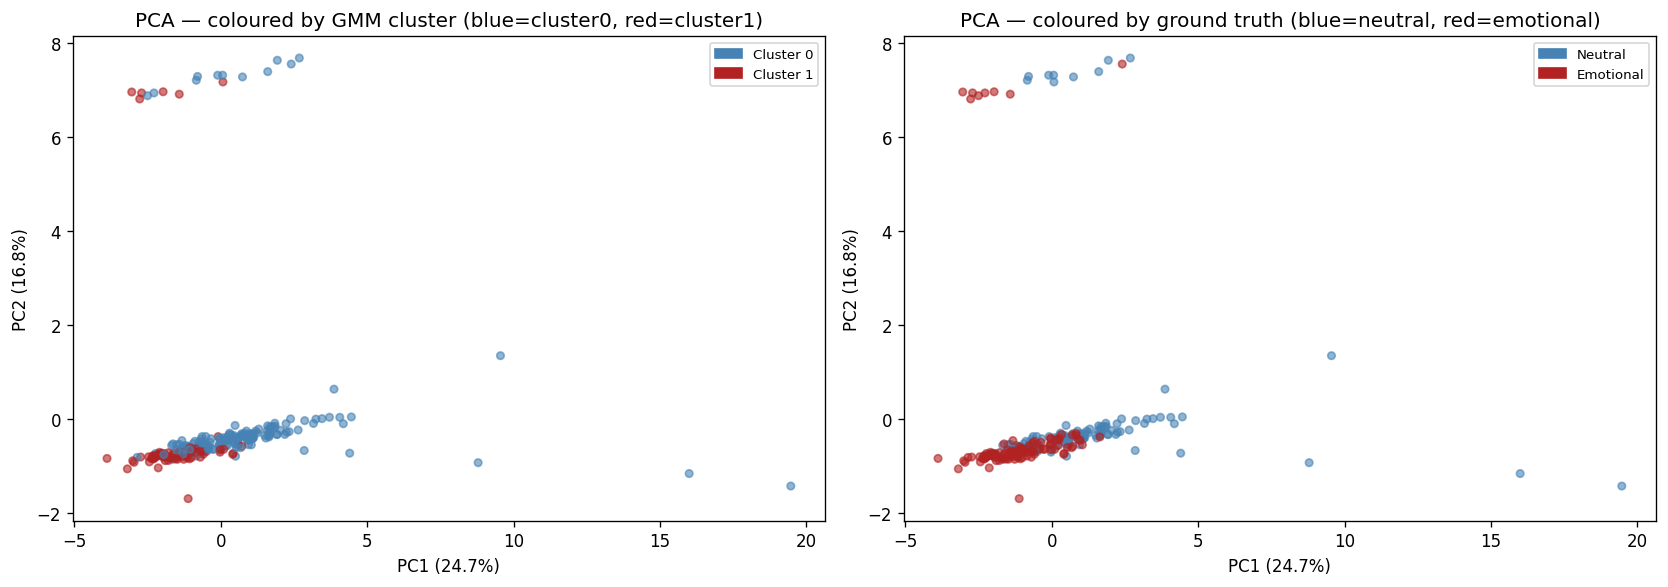

PCA explained variance: PC1=24.7%, PC2=16.8%


In [119]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X[top_features].values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: colour by GMM cluster assignment
ax = axes[0]
colors_pred = ['steelblue' if l == 0 else 'firebrick' for l in gmm_labels]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors_pred, alpha=0.6, s=20)
ax.set_title('PCA — coloured by GMM cluster (blue=cluster0, red=cluster1)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Right: colour by ground truth
ax = axes[1]
gt_colors = ['steelblue' if yi == 0 else 'firebrick' for yi in y]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=gt_colors, alpha=0.6, s=20)
ax.set_title('PCA — coloured by ground truth (blue=neutral, red=emotional)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Custom legends
from matplotlib.patches import Patch
axes[0].legend(handles=[Patch(color='steelblue', label='Cluster 0'),
                         Patch(color='firebrick', label='Cluster 1')], fontsize=8)
axes[1].legend(handles=[Patch(color='steelblue', label='Neutral'),
                         Patch(color='firebrick', label='Emotional')], fontsize=8)

plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_pca_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'PCA explained variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}')

## 12 — Feature correlation matrix (top features)

Identify redundant features. Correlated features (|r|>0.9) carry overlapping information
and should be pruned to one representative per cluster.

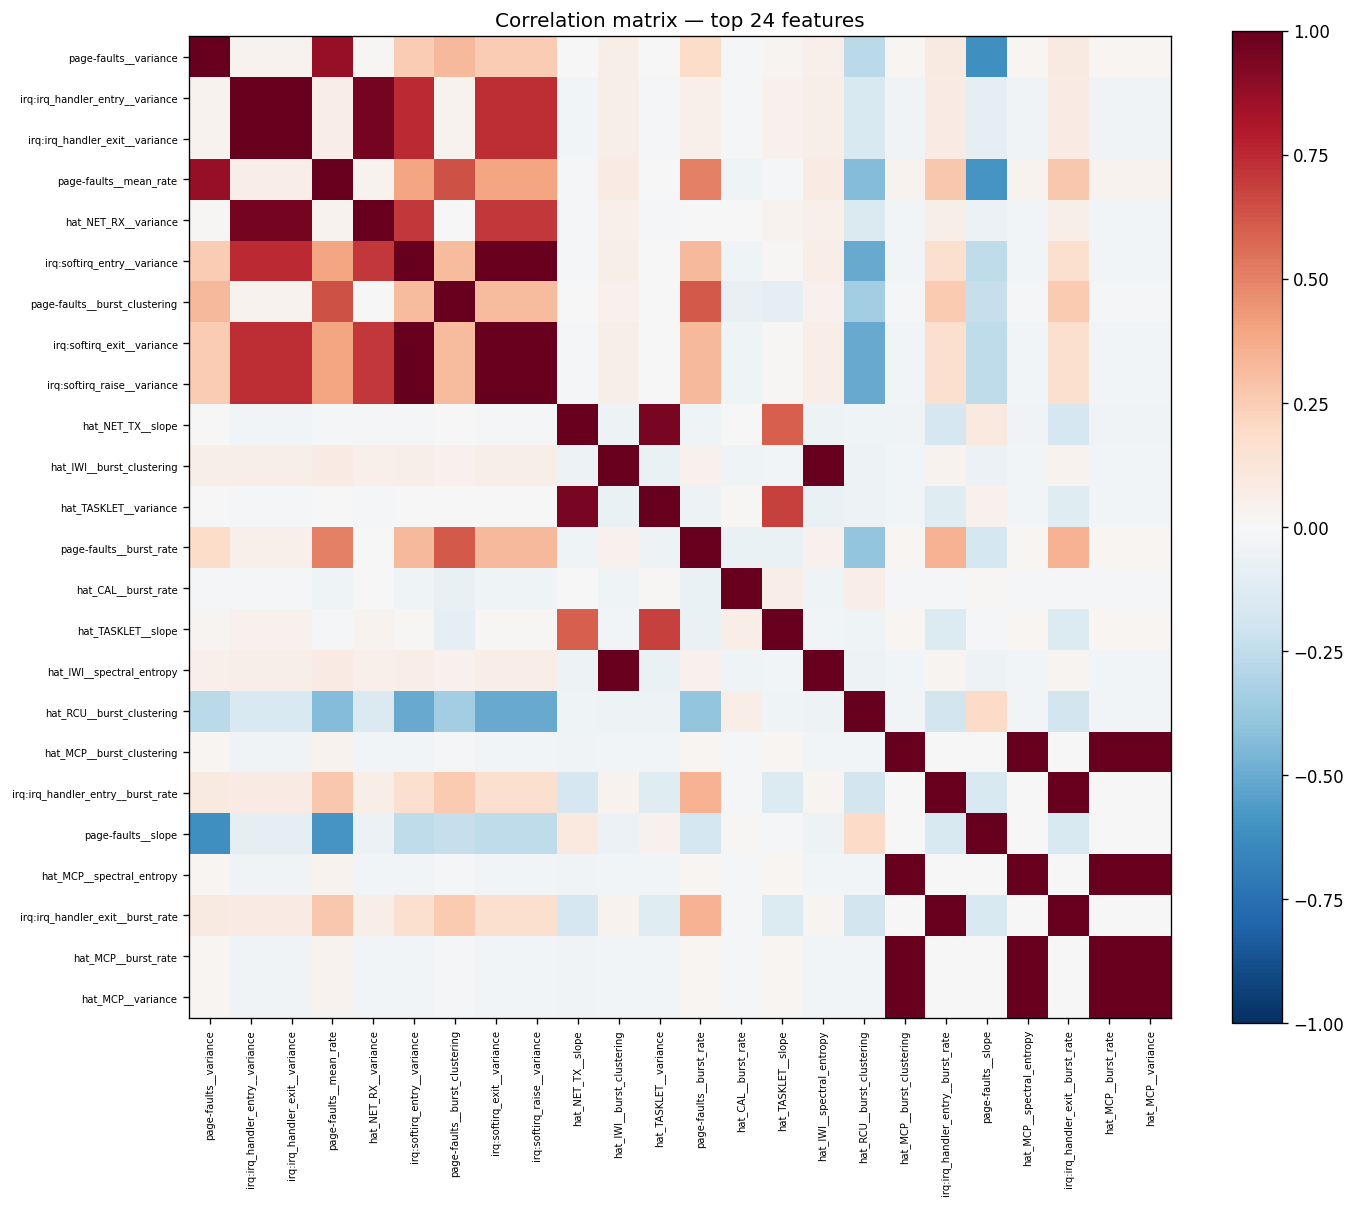

Highly correlated pairs (|r|>0.9): 15
                        feature_A                        feature_B     r
  irq:irq_handler_entry__variance   irq:irq_handler_exit__variance 1.000
  irq:irq_handler_entry__variance             hat_NET_RX__variance 0.957
   irq:irq_handler_exit__variance             hat_NET_RX__variance 0.957
      irq:softirq_entry__variance       irq:softirq_exit__variance 1.000
      irq:softirq_entry__variance      irq:softirq_raise__variance 1.000
       irq:softirq_exit__variance      irq:softirq_raise__variance 1.000
                hat_NET_TX__slope            hat_TASKLET__variance 0.948
        hat_IWI__burst_clustering        hat_IWI__spectral_entropy 0.999
        hat_MCP__burst_clustering        hat_MCP__spectral_entropy 1.000
        hat_MCP__burst_clustering              hat_MCP__burst_rate 1.000
        hat_MCP__burst_clustering                hat_MCP__variance 1.000
irq:irq_handler_entry__burst_rate irq:irq_handler_exit__burst_rate 1.000
        hat_M

In [120]:
CORR_TOP = min(30, len(top_features))
corr = X[ranking.head(CORR_TOP)['feature'].tolist()].corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(im, ax=ax)
ax.set_xticks(range(CORR_TOP))
ax.set_yticks(range(CORR_TOP))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=6)
ax.set_yticklabels(corr.index, fontsize=6)
ax.set_title(f'Correlation matrix — top {CORR_TOP} features')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Report highly correlated pairs
high_corr = []
cols = list(corr.columns)
for i, a in enumerate(cols):
    for j, b in enumerate(cols):
        if j <= i:
            continue
        r = corr.loc[a, b]
        if abs(r) > 0.9:
            high_corr.append({'feature_A': a, 'feature_B': b, 'r': r})
if high_corr:
    print(f'Highly correlated pairs (|r|>0.9): {len(high_corr)}')
    print(pd.DataFrame(high_corr).to_string(index=False, float_format='{:.3f}'.format))
else:
    print('No highly correlated pairs among top features.')

## 13 — Per-indicator: which metrics drive each indicator?

For each HAT indicator, show which of the 10 metrics has the best silhouette.
This tells you not just *that* an indicator differs, but *how* it differs.

=== Best metric per indicator (top 30 by silhouette) ===
              indicator           metric  silhouette     ari
                hat_MCP burst_clustering      0.9994 -0.0010
                hat_TLB burst_clustering      0.9953 -0.0017
                hat_CAL       burst_rate      0.9951  0.0000
             hat_NET_TX burst_clustering      0.9947  0.0018
                hat_IWI           iat_cv      0.9907  0.0000
              hat_BLOCK         variance      0.9846 -0.0007
            hat_TASKLET         variance      0.9828  0.0000
            page-faults         variance      0.9702  0.0001
  irq:irq_handler_entry         variance      0.9648  0.0004
   irq:irq_handler_exit         variance      0.9648  0.0004
             hat_NET_RX         variance      0.9617  0.0008
msr/cpu_thermal_margin/ spectral_entropy      0.9149 -0.0003
       dTLB-load-misses       burst_rate      0.8850 -0.0031
      irq:softirq_entry         variance      0.8844  0.0001
       irq:softirq_exit     

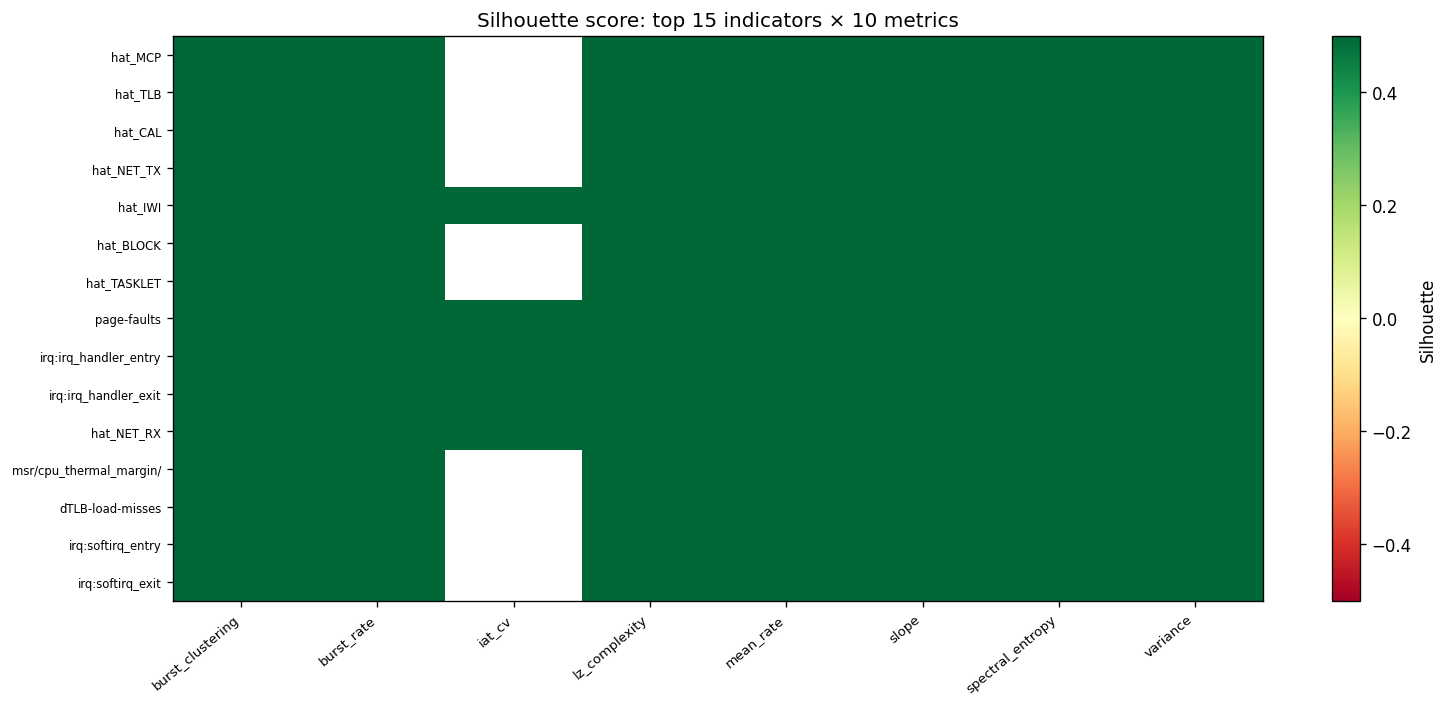

In [121]:
# Parse feature names: indicator__metric
def parse_feature(fname):
    parts = fname.rsplit('__', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return fname, ''

clust_df['indicator'] = clust_df.feature.apply(lambda f: parse_feature(f)[0])
clust_df['metric']    = clust_df.feature.apply(lambda f: parse_feature(f)[1])

# Best metric per indicator
best_per_ind = (clust_df
    .sort_values('silhouette', ascending=False)
    .groupby('indicator')
    .first()
    .reset_index()
    [['indicator', 'metric', 'silhouette', 'ari']]
    .sort_values('silhouette', ascending=False)
)

print('=== Best metric per indicator (top 30 by silhouette) ===')
print(best_per_ind.head(30).to_string(index=False, float_format='{:.4f}'.format))

# Heatmap: indicators × metrics, silhouette value
top_inds = best_per_ind.head(15)['indicator'].tolist()
pivot = clust_df[clust_df.indicator.isin(top_inds)].pivot_table(
    index='indicator', columns='metric', values='silhouette', aggfunc='first')
pivot = pivot.reindex(index=top_inds)

fig, ax = plt.subplots(figsize=(13, 6))
im = ax.imshow(pivot.values, cmap='RdYlGn', vmin=-0.5, vmax=0.5, aspect='auto')
plt.colorbar(im, ax=ax, label='Silhouette')
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=40, ha='right', fontsize=8)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels([s[:40] for s in pivot.index], fontsize=7)
ax.set_title('Silhouette score: top 15 indicators × 10 metrics')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_indicator_metric_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 14 — Final: single-metric distribution plots for top features

For the top 6 features by composite rank, show overlapping KDEs for
neutral vs emotional — the visual confirmation of cluster separation.

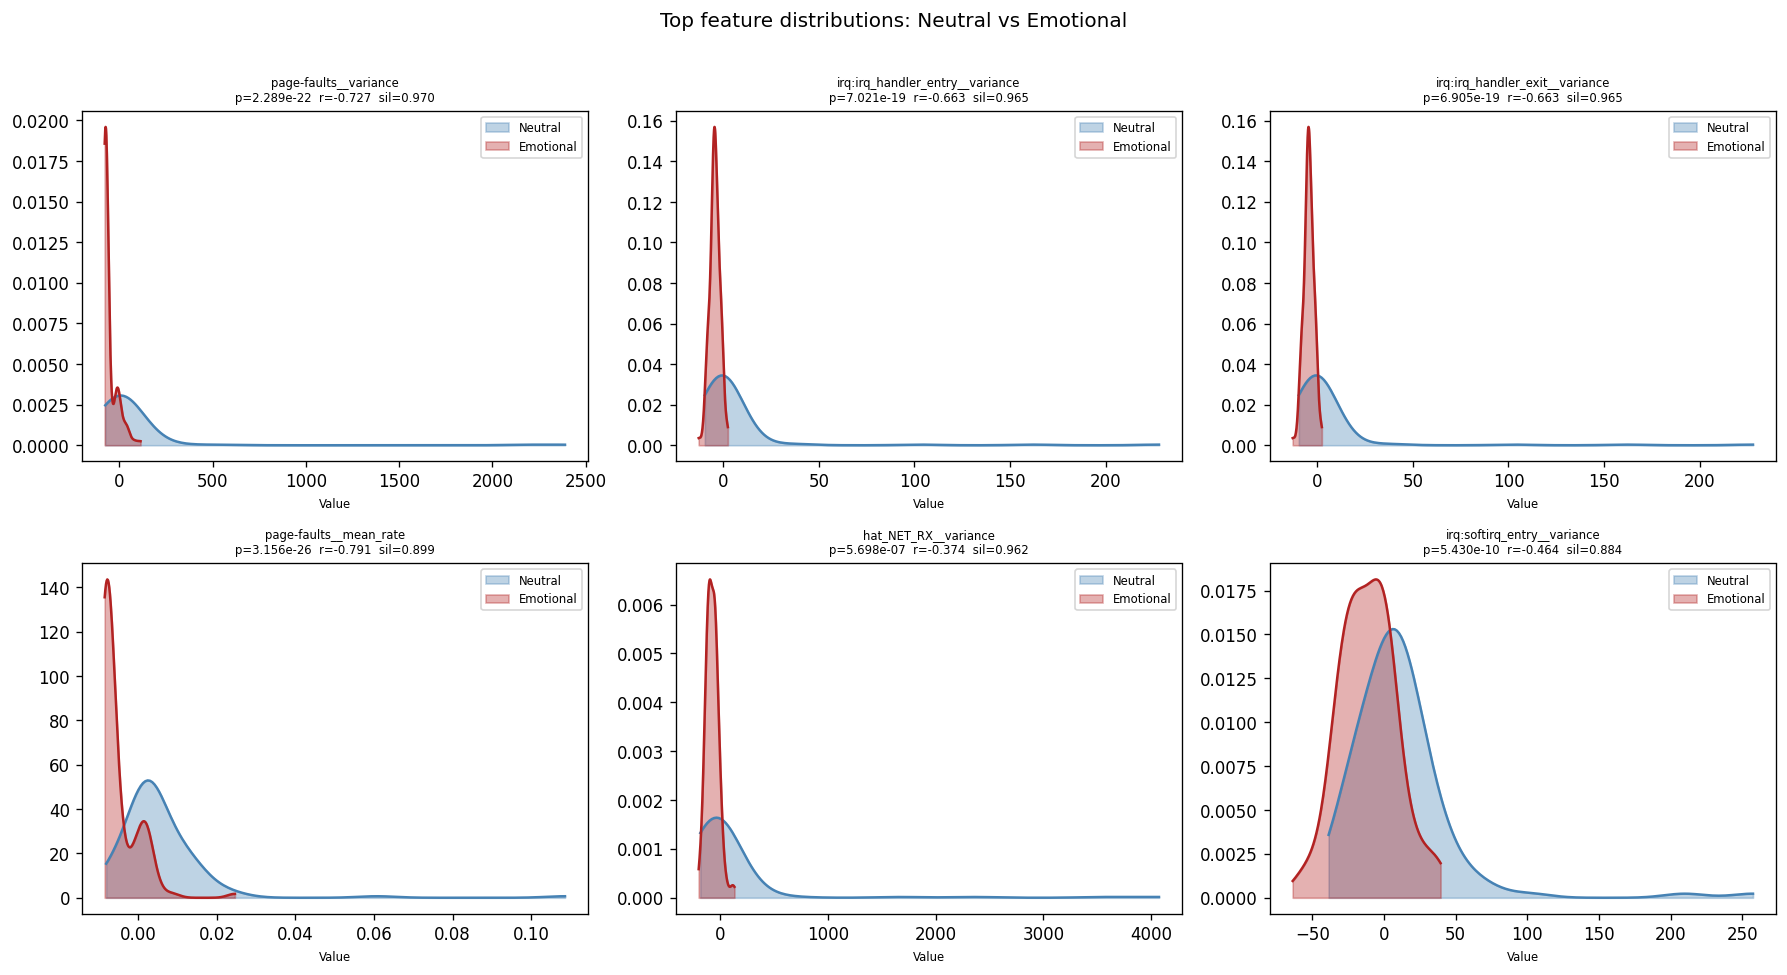

In [122]:
from scipy.stats import gaussian_kde

TOP_PLOT = 6
plot_features = ranking.head(TOP_PLOT)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, feat in enumerate(plot_features):
    ax = axes[i]
    n_vals_f = X_raw[feat][y == 0].dropna().values
    e_vals_f = X_raw[feat][y == 1].dropna().values

    for vals, label, color in [
        (n_vals_f, 'Neutral',   'steelblue'),
        (e_vals_f, 'Emotional', 'firebrick'),
    ]:
        if len(vals) < 3:
            continue
        kde = gaussian_kde(vals, bw_method='scott')
        x_range = np.linspace(vals.min(), vals.max(), 200)
        ax.fill_between(x_range, kde(x_range), alpha=0.35, color=color, label=label)
        ax.plot(x_range, kde(x_range), color=color, lw=1.5)

    # Get stats from ranking
    row = ranking[ranking.feature == feat].iloc[0]
    ax.set_title(f'{feat}\np={row.p:.3e}  r={row.effect_r:.3f}  sil={row.silhouette:.3f}',
                 fontsize=7)
    ax.set_xlabel('Value', fontsize=7)
    ax.legend(fontsize=7)

plt.suptitle('Top feature distributions: Neutral vs Emotional', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_top_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 15 — Summary table

The final output: which features survive both univariate screening and clustering,
ranked by composite score. These are the indicators to carry forward.

In [123]:
summary = ranking.copy()
summary['indicator'] = summary.feature.apply(lambda f: parse_feature(f)[0])
summary['metric']    = summary.feature.apply(lambda f: parse_feature(f)[1])

# Flag if length-confounded: metrics NOT normalised by duration
non_normalised = ['variance', 'p90_p10', 'lz_complexity', 'perm_entropy']
summary['length_sensitive'] = summary.metric.isin(non_normalised) & LENGTH_CONFOUNDED

final_cols = ['composite_rank','indicator','metric','p','effect_r','direction',
              'silhouette','ari','purity','length_sensitive']
print('=== Final metric ranking (top 40) ===')
print(summary.head(40)[final_cols].to_string(index=False, float_format='{:.4f}'.format))

summary[final_cols].to_csv(BASE_DIR / 'final_metric_ranking.csv', index=False)
print(f'\nSaved → {BASE_DIR}/final_metric_ranking.csv')

=== Final metric ranking (top 40) ===
 composite_rank               indicator           metric      p  effect_r direction  silhouette     ari  purity  length_sensitive
        15.5000             page-faults         variance 0.0000   -0.7267        ↓E      0.9702  0.0001  0.7521             False
        20.5000   irq:irq_handler_entry         variance 0.0000   -0.6629        ↓E      0.9648  0.0004  0.7532             False
        20.5000    irq:irq_handler_exit         variance 0.0000   -0.6631        ↓E      0.9648  0.0004  0.7532             False
        23.0000             page-faults        mean_rate 0.0000   -0.7914        ↓E      0.8986  0.0001  0.7521             False
        30.5000              hat_NET_RX         variance 0.0000   -0.3736        ↓E      0.9617  0.0008  0.7542             False
        33.0000       irq:softirq_entry         variance 0.0000   -0.4636        ↓E      0.8844  0.0001  0.7521             False
        33.5000             page-faults burst_cluste

## 16 — Diagnosing what 'indicator' actually means in this dataset

**This section is essential to run before any per-indicator clustering.**

The feature column names look like `<indicator>__<metric>` (e.g. `hat_LOC__mean_rate`).
But before treating each unique `indicator` part as a meaningful HAT indicator, we need
to verify the structure is what we expect:

### Expected structure
- ~20 named HAT indicators: `hat_LOC`, `hat_CAL`, `hat_HRTIMER`, `hat_MCP`, `hat_TASKLET`,
  `hat_IWI`, `hat_NMI`, `hat_SCHED`, `hat_RCU`, `hat_BLOCK`, etc. — named softirq/interrupt types
- ~10 perf hardware/software counters: `cache-misses`, `cycles`, `branch-misses`, etc.
- 1 synthetic CPU frequency indicator: `cpu_freq_mean`
- Each of the above should have up to 10 metric columns

### What can go wrong
1. **Numeric IRQ explosion**: `/proc/interrupts` has one row per IRQ number (0–700+).
   If the collector prefixes *every row* with `hat_`, we get hundreds of `hat_0`,
   `hat_120`, `hat_447` ... indicators instead of ~20. This is a naming problem,
   not a data problem.
2. **Metric count mismatch**: Some indicators may only have 1 or 9 metrics instead of 10.
   This happens when `iat_cv` (event-type metric) returns NaN for PCI-type indicators
   and gets dropped by the zero-variance filter in §6.
3. **Duplicate information**: Many numeric IRQ lines in `/proc/interrupts` may belong
   to the same device/driver, so they're not independent indicators.

The cells below print a full audit of what we have.

In [124]:
# Parse feature names: indicator__metric
def parse_feature(fname):
    parts = fname.rsplit('__', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return fname, ''

METRIC_NAMES = ['mean_rate','variance','p90_p10','slope','spectral_entropy',
                'iat_cv','burst_rate','burst_clustering','lz_complexity','perm_entropy']

# Build indicator → list of metric columns mapping
# This includes EVERY unique indicator prefix in the feature matrix
from collections import defaultdict
ind_map_raw = defaultdict(list)
for col in feat_cols:
    indicator, metric = parse_feature(col)
    if metric in METRIC_NAMES:
        ind_map_raw[indicator].append(col)
ind_map_raw = dict(ind_map_raw)

print(f'Total indicators found in feature matrix: {len(ind_map_raw)}')
print()

# Categorise each indicator by type
import re

def classify_indicator(name):
    """Classify an indicator name into a category."""
    if re.fullmatch(r'hat_\d+', name):
        return 'numeric_irq'      # e.g. hat_190, hat_447 — raw /proc/interrupts rows
    elif name.startswith('hat_') and name[4:].isupper():
        return 'named_softirq'    # e.g. hat_HRTIMER, hat_LOC, hat_MCP
    elif name.startswith('hat_') and name[4:].isalpha():
        return 'named_softirq'    # e.g. hat_CAL
    elif name.startswith('hat_'):
        return 'hat_other'        # e.g. hat_LOC (mixed)
    elif name == 'cpu_freq_mean':
        return 'cpu_freq'
    else:
        return 'perf_counter'     # e.g. cache-misses, cycles, context-switches

category_counts = defaultdict(int)
for ind in ind_map_raw:
    category_counts[classify_indicator(ind)] += 1

print('=== Indicator categories ===')
for cat, n in sorted(category_counts.items(), key=lambda x: -x[1]):
    print(f'  {cat:20s}: {n:4d} indicators')

print()
print('=== Named softirq / hat indicators (the ~20 we care about) ===')
named = {k: v for k, v in ind_map_raw.items()
         if classify_indicator(k) in ('named_softirq', 'hat_other', 'cpu_freq')}
for ind, cols in sorted(named.items()):
    metrics_present = sorted([parse_feature(c)[1] for c in cols])
    missing = [m for m in METRIC_NAMES if m not in metrics_present]
    flag = '  ← MISSING METRICS: ' + ', '.join(missing) if missing else ''
    print(f'  {ind:20s}: {len(cols):2d} metrics  [{', '.join(metrics_present)}]{flag}')

print()
print('=== Perf hardware/software counters ===')
perf = {k: v for k, v in ind_map_raw.items() if classify_indicator(k) == 'perf_counter'}
for ind, cols in sorted(perf.items()):
    metrics_present = sorted([parse_feature(c)[1] for c in cols])
    missing = [m for m in METRIC_NAMES if m not in metrics_present]
    flag = '  ← MISSING: ' + ', '.join(missing) if missing else ''
    print(f'  {ind:30s}: {len(cols):2d} metrics{flag}')

print()
print('=== Numeric IRQ indicators (first 20 shown) ===')
numeric = {k: v for k, v in ind_map_raw.items() if classify_indicator(k) == 'numeric_irq'}
for ind, cols in sorted(numeric.items(), key=lambda x: int(x[0].split('_')[1]))[:20]:
    metrics_present = sorted([parse_feature(c)[1] for c in cols])
    print(f'  {ind:15s}: {len(cols):2d} metrics  [{', '.join(metrics_present)}]')
print(f'  ... and {len(numeric)-20} more numeric IRQ indicators')

Total indicators found in feature matrix: 52

=== Indicator categories ===
  named_softirq       :   29 indicators
  perf_counter        :   22 indicators
  cpu_freq            :    1 indicators

=== Named softirq / hat indicators (the ~20 we care about) ===
  cpu_freq_mean       :  7 metrics  [burst_clustering, burst_rate, lz_complexity, mean_rate, slope, spectral_entropy, variance]  ← MISSING METRICS: p90_p10, iat_cv, perm_entropy
  hat_BLOCK           :  7 metrics  [burst_clustering, burst_rate, lz_complexity, mean_rate, slope, spectral_entropy, variance]  ← MISSING METRICS: p90_p10, iat_cv, perm_entropy
  hat_CAL             :  7 metrics  [burst_clustering, burst_rate, lz_complexity, mean_rate, slope, spectral_entropy, variance]  ← MISSING METRICS: p90_p10, iat_cv, perm_entropy
  hat_DFR             :  1 metrics  [lz_complexity]  ← MISSING METRICS: mean_rate, variance, p90_p10, slope, spectral_entropy, iat_cv, burst_rate, burst_clustering, perm_entropy
  hat_ERR             :  1 me

### Interpretation

The output above will reveal the structure. Here's what each category means:

**`named_softirq`** (e.g. `hat_HRTIMER`, `hat_LOC`, `hat_MCP`, `hat_CAL`, `hat_TASKLET`,
`hat_NMI`, `hat_SCHED`, `hat_RCU`, `hat_BLOCK`, `hat_NET_RX`, `hat_NET_TX`, `hat_IWI`):  
These are rows from `/proc/softirqs` — the actual meaningful high-level interrupt categories
in the Linux kernel. These are what a HAT thesis would treat as distinct indicators.
**These are the ~10–20 we want.**

**`numeric_irq`** (e.g. `hat_190`, `hat_447`, `hat_603`):  
These are *individual hardware IRQ lines* from `/proc/interrupts`. Linux assigns a numeric
ID to every physical interrupt source (NIC, NVME, USB controller, etc.). A modern server
can have 600+ of these. They are **not** independent HAT indicators — they are lower-level
than the softirq mechanism and many correspond to the same device.

**`perf_counter`** (e.g. `cache-misses`, `cycles`, `dTLB-load-misses`):  
These are perf PMU hardware/software counters. Each is a valid HAT PCI indicator.

### The fix
For the per-indicator analysis, we define **two views**:

1. **`ind_map_named`**: only named softirq + perf counters + cpu_freq — the ~20–25
   semantically meaningful indicators your thesis uses.
2. **`ind_map_all`**: everything including numeric IRQs — used for completeness but
   results are expected to be highly redundant.

Going forward, the main analysis uses `ind_map_named`.

In [125]:
# Build the two indicator maps
NAMED_CATEGORIES = {'named_softirq', 'hat_other', 'cpu_freq', 'perf_counter'}

ind_map_named = {k: v for k, v in ind_map_raw.items()
                 if classify_indicator(k) in NAMED_CATEGORIES}
ind_map_all   = ind_map_raw  # full map including numeric IRQs

print(f'Named/semantic indicators: {len(ind_map_named)}')
print(f'All indicators (incl. numeric IRQs): {len(ind_map_all)}')
print()
print('Named indicators and their metric counts:')
for ind, cols in sorted(ind_map_named.items()):
    n_metrics = len(cols)
    metrics = sorted([parse_feature(c)[1] for c in cols])
    print(f'  {ind:30s}: {n_metrics:2d} metrics')

print()
print('NOTE: Expected 10 metrics each. If any show <10, check which ones are missing above.')
print('  iat_cv is intentionally NaN for PCIs (perf counters sampled at fixed interval).')
print('  If it is also missing for named softirqs (event-indicators), that is a bug.')

Named/semantic indicators: 52
All indicators (incl. numeric IRQs): 52

Named indicators and their metric counts:
  LLC-load-misses               :  7 metrics
  branch-instructions           :  7 metrics
  branch-misses                 :  7 metrics
  cache-misses                  :  7 metrics
  cache-references              :  7 metrics
  context-switches              :  7 metrics
  cpu-clock                     :  7 metrics
  cpu-migrations                :  7 metrics
  cpu_freq_mean                 :  7 metrics
  cycles                        :  7 metrics
  dTLB-load-misses              :  7 metrics
  hat_BLOCK                     :  7 metrics
  hat_CAL                       :  7 metrics
  hat_DFR                       :  1 metrics
  hat_ERR                       :  1 metrics
  hat_HI                        :  1 metrics
  hat_HRTIMER                   :  1 metrics
  hat_IRQ_POLL                  :  1 metrics
  hat_IWI                       :  8 metrics
  hat_LOC                       

## 17 — Per-indicator clustering: all metrics jointly (named indicators only)

For each **named HAT indicator**, we collect all of its available metric columns
(up to 10) as a feature vector (one row per trial), then fit:
- **KMeans k=2** — hard geometric clusters
- **GMM k=2** — soft probabilistic clusters, generally better for overlapping distributions

Both are evaluated against the ground-truth labels:
- **ARI** (Adjusted Rand Index): 0 = random, 1 = perfect. Negative = worse than random.
- **Accuracy**: fraction of trials correctly assigned to neutral/emotional cluster.
- **Per-class accuracy** (`n_acc`, `e_acc`): are both conditions separated, or just one?
- **Silhouette**: geometric compactness of the clusters (-1 to 1), independent of labels.

The key question here is: *as a whole, does the multi-dimensional fingerprint of this
indicator separate emotional from neutral computation?*

In [126]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


def cluster_and_score(X_ind: np.ndarray, y_true: np.ndarray, name: str) -> dict:
    """
    Fit k=2 KMeans and GMM on X_ind, score vs ground-truth labels.
    
    Parameters
    ----------
    X_ind   : (n_samples, n_features) array — metric values for one indicator
    y_true  : (n_samples,) array — 0=neutral, 1=emotional
    name    : indicator name (for reporting)
    
    Returns dict with km_* and gmm_* fields.
    """
    result = {'indicator': name, 'n_metrics': X_ind.shape[1]}

    # Drop rows where any metric is NaN/Inf
    mask = np.isfinite(X_ind).all(axis=1)
    Xc = X_ind[mask]
    yc = y_true[mask]
    result['n_samples'] = int(mask.sum())

    nan_rows = int((~mask).sum())
    if nan_rows > 0:
        result['nan_rows_dropped'] = nan_rows

    # Need at least both classes and 10+ samples to cluster
    if len(np.unique(yc)) < 2 or Xc.shape[0] < 10:
        result.update({'km_ari': np.nan, 'km_acc': np.nan, 'km_sil': np.nan,
                       'gmm_ari': np.nan, 'gmm_acc': np.nan, 'gmm_sil': np.nan,
                       'km_n_acc': np.nan, 'km_e_acc': np.nan,
                       'gmm_n_acc': np.nan, 'gmm_e_acc': np.nan,
                       'skip_reason': 'insufficient data'})
        return result

    sc = StandardScaler()
    Xs = sc.fit_transform(Xc)

    for tag, model in [
        ('km',  KMeans(n_clusters=2, random_state=42, n_init=20)),
        ('gmm', GaussianMixture(n_components=2, covariance_type='full',
                                random_state=42, n_init=10)),
    ]:
        lbl = model.fit_predict(Xs)

        ari = adjusted_rand_score(yc, lbl)
        sil = silhouette_score(Xs, lbl) if len(np.unique(lbl)) > 1 else np.nan

        # Align cluster label orientation to ground truth
        # (cluster IDs are arbitrary; flip if that improves accuracy)
        acc_direct  = (lbl == yc).mean()
        acc_flipped = (1 - lbl == yc).mean()
        if acc_flipped > acc_direct:
            lbl = 1 - lbl
        acc = (lbl == yc).mean()

        # Per-class accuracy: what fraction of each condition was correctly assigned?
        n_acc = (lbl[yc == 0] == 0).mean() if (yc == 0).sum() > 0 else np.nan
        e_acc = (lbl[yc == 1] == 1).mean() if (yc == 1).sum() > 0 else np.nan

        result.update({
            f'{tag}_ari':   ari,
            f'{tag}_acc':   acc,
            f'{tag}_sil':   sil,
            f'{tag}_n_acc': n_acc,
            f'{tag}_e_acc': e_acc,
        })

    return result


# ── Run per-indicator multi-metric clustering (named indicators only) ──
print('Running per-indicator clustering on NAMED indicators only...')
print(f'(Using ind_map_named with {len(ind_map_named)} indicators)')
print()

ind_results = []
for indicator, cols in sorted(ind_map_named.items()):
    X_ind = X_raw[cols].values.astype(float)
    res = cluster_and_score(X_ind, y, indicator)
    ind_results.append(res)
    # Verbose per-indicator output so you can follow progress
    n_met = res['n_metrics']
    ari   = res.get('gmm_ari', np.nan)
    acc   = res.get('gmm_acc', np.nan)
    skip  = res.get('skip_reason', '')
    nan_d = res.get('nan_rows_dropped', 0)
    nan_msg = f' [{nan_d} rows had NaN → dropped]' if nan_d else ''
    if np.isnan(ari):
        print(f'  {indicator:30s}: SKIPPED ({skip}){nan_msg}')
    else:
        bar = '█' * int(ari * 20) if ari > 0 else ''
        print(f'  {indicator:30s}: {n_met:2d} metrics  GMM ARI={ari:.3f} acc={acc:.1%}  {bar}{nan_msg}')

ind_df = (pd.DataFrame(ind_results)
            .sort_values('gmm_ari', ascending=False)
            .reset_index(drop=True))

print()
print(f'Done. {len(ind_df)} indicators processed.')

Running per-indicator clustering on NAMED indicators only...
(Using ind_map_named with 52 indicators)

  LLC-load-misses               :  7 metrics  GMM ARI=-0.003 acc=51.7%  
  branch-instructions           :  7 metrics  GMM ARI=-0.002 acc=52.1%  
  branch-misses                 :  7 metrics  GMM ARI=-0.002 acc=52.5%  
  cache-misses                  :  7 metrics  GMM ARI=-0.002 acc=52.5%  
  cache-references              :  7 metrics  GMM ARI=0.000 acc=52.9%  
  context-switches              :  7 metrics  GMM ARI=-0.002 acc=50.0%  
  cpu-clock                     :  7 metrics  GMM ARI=-0.004 acc=50.0%  
  cpu-migrations                :  7 metrics  GMM ARI=0.001 acc=52.9%  
  cpu_freq_mean                 :  7 metrics  GMM ARI=0.010 acc=55.8%  
  cycles                        :  7 metrics  GMM ARI=-0.004 acc=51.2%  
  dTLB-load-misses              :  7 metrics  GMM ARI=-0.003 acc=50.4%  
  hat_BLOCK                     :  7 metrics  GMM ARI=-0.001 acc=50.0%  
  hat_CAL               

### Per-indicator summary table

Columns:
- `n_metrics`: how many metric columns were available for this indicator
- `n_samples`: samples actually used (after NaN rows dropped)
- `gmm_ari`: ARI of GMM clustering vs ground truth (main score)
- `gmm_acc`: overall accuracy (after aligning cluster labels to GT)
- `gmm_n_acc` / `gmm_e_acc`: per-class accuracy — are *both* conditions separated?
- `km_ari`: same but for KMeans (less sensitive than GMM for unequal covariance)

**Interpreting ARI:**
- ARI ≈ 1.0: near-perfect separation — the indicator's joint metric signature cleanly
  distinguishes emotional from neutral trials
- ARI ≈ 0.0: random — the indicator provides no discriminative signal
- ARI < 0: clustering is worse than random (unusual — check if it flips between runs)

**Interpreting asymmetric per-class accuracy (e.g. n_acc=1.0 but e_acc=0.5):**
This means the indicator reliably identifies one condition but not the other —
a selective rather than bilateral separating indicator.

In [127]:
show_cols = ['indicator','n_metrics','n_samples',
             'gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc','gmm_sil',
             'km_ari', 'km_acc']
print('=== Per-indicator clustering results (sorted by GMM ARI) ===')
print(ind_df[show_cols].to_string(index=False, float_format='{:.3f}'.format))

# How many indicators achieve meaningful separation?
print()
good = ind_df[ind_df.gmm_ari > 0.1]
ok   = ind_df[(ind_df.gmm_ari > 0.0) & (ind_df.gmm_ari <= 0.1)]
bad  = ind_df[ind_df.gmm_ari <= 0.0]
nan_  = ind_df[ind_df.gmm_ari.isna()]
print(f'ARI > 0.10 (good separation):    {len(good):3d} indicators')
print(f'ARI 0–0.10 (weak separation):    {len(ok):3d} indicators')
print(f'ARI ≤ 0 (no/negative separation):{len(bad):3d} indicators')
print(f'Skipped (insufficient data):     {len(nan_):3d} indicators')

ind_df.to_csv(BASE_DIR / 'per_indicator_clustering.csv', index=False)
print(f'\nSaved → {BASE_DIR}/per_indicator_clustering.csv')

=== Per-indicator clustering results (sorted by GMM ARI) ===
              indicator  n_metrics  n_samples  gmm_ari  gmm_acc  gmm_n_acc  gmm_e_acc  gmm_sil  km_ari  km_acc
            page-faults          8        240    0.378    0.808      0.875      0.742    0.281   0.399   0.817
              hat_TIMER          7        240    0.040    0.604      0.350      0.858    0.208   0.019   0.575
                hat_RCU          8        240    0.030    0.592      0.375      0.808    0.220   0.043   0.608
          cpu_freq_mean          7        240    0.010    0.558      0.442      0.675    0.140   0.000   0.533
                hat_IWI          8        240    0.006    0.550      0.392      0.708    0.782   0.006   0.550
              hat_SCHED          7        240    0.006    0.550      0.558      0.542    0.151   0.030   0.592
  irq:irq_handler_entry          8        240    0.005    0.537      0.075      1.000    0.532   0.290   0.771
   irq:irq_handler_exit          8        240    0.

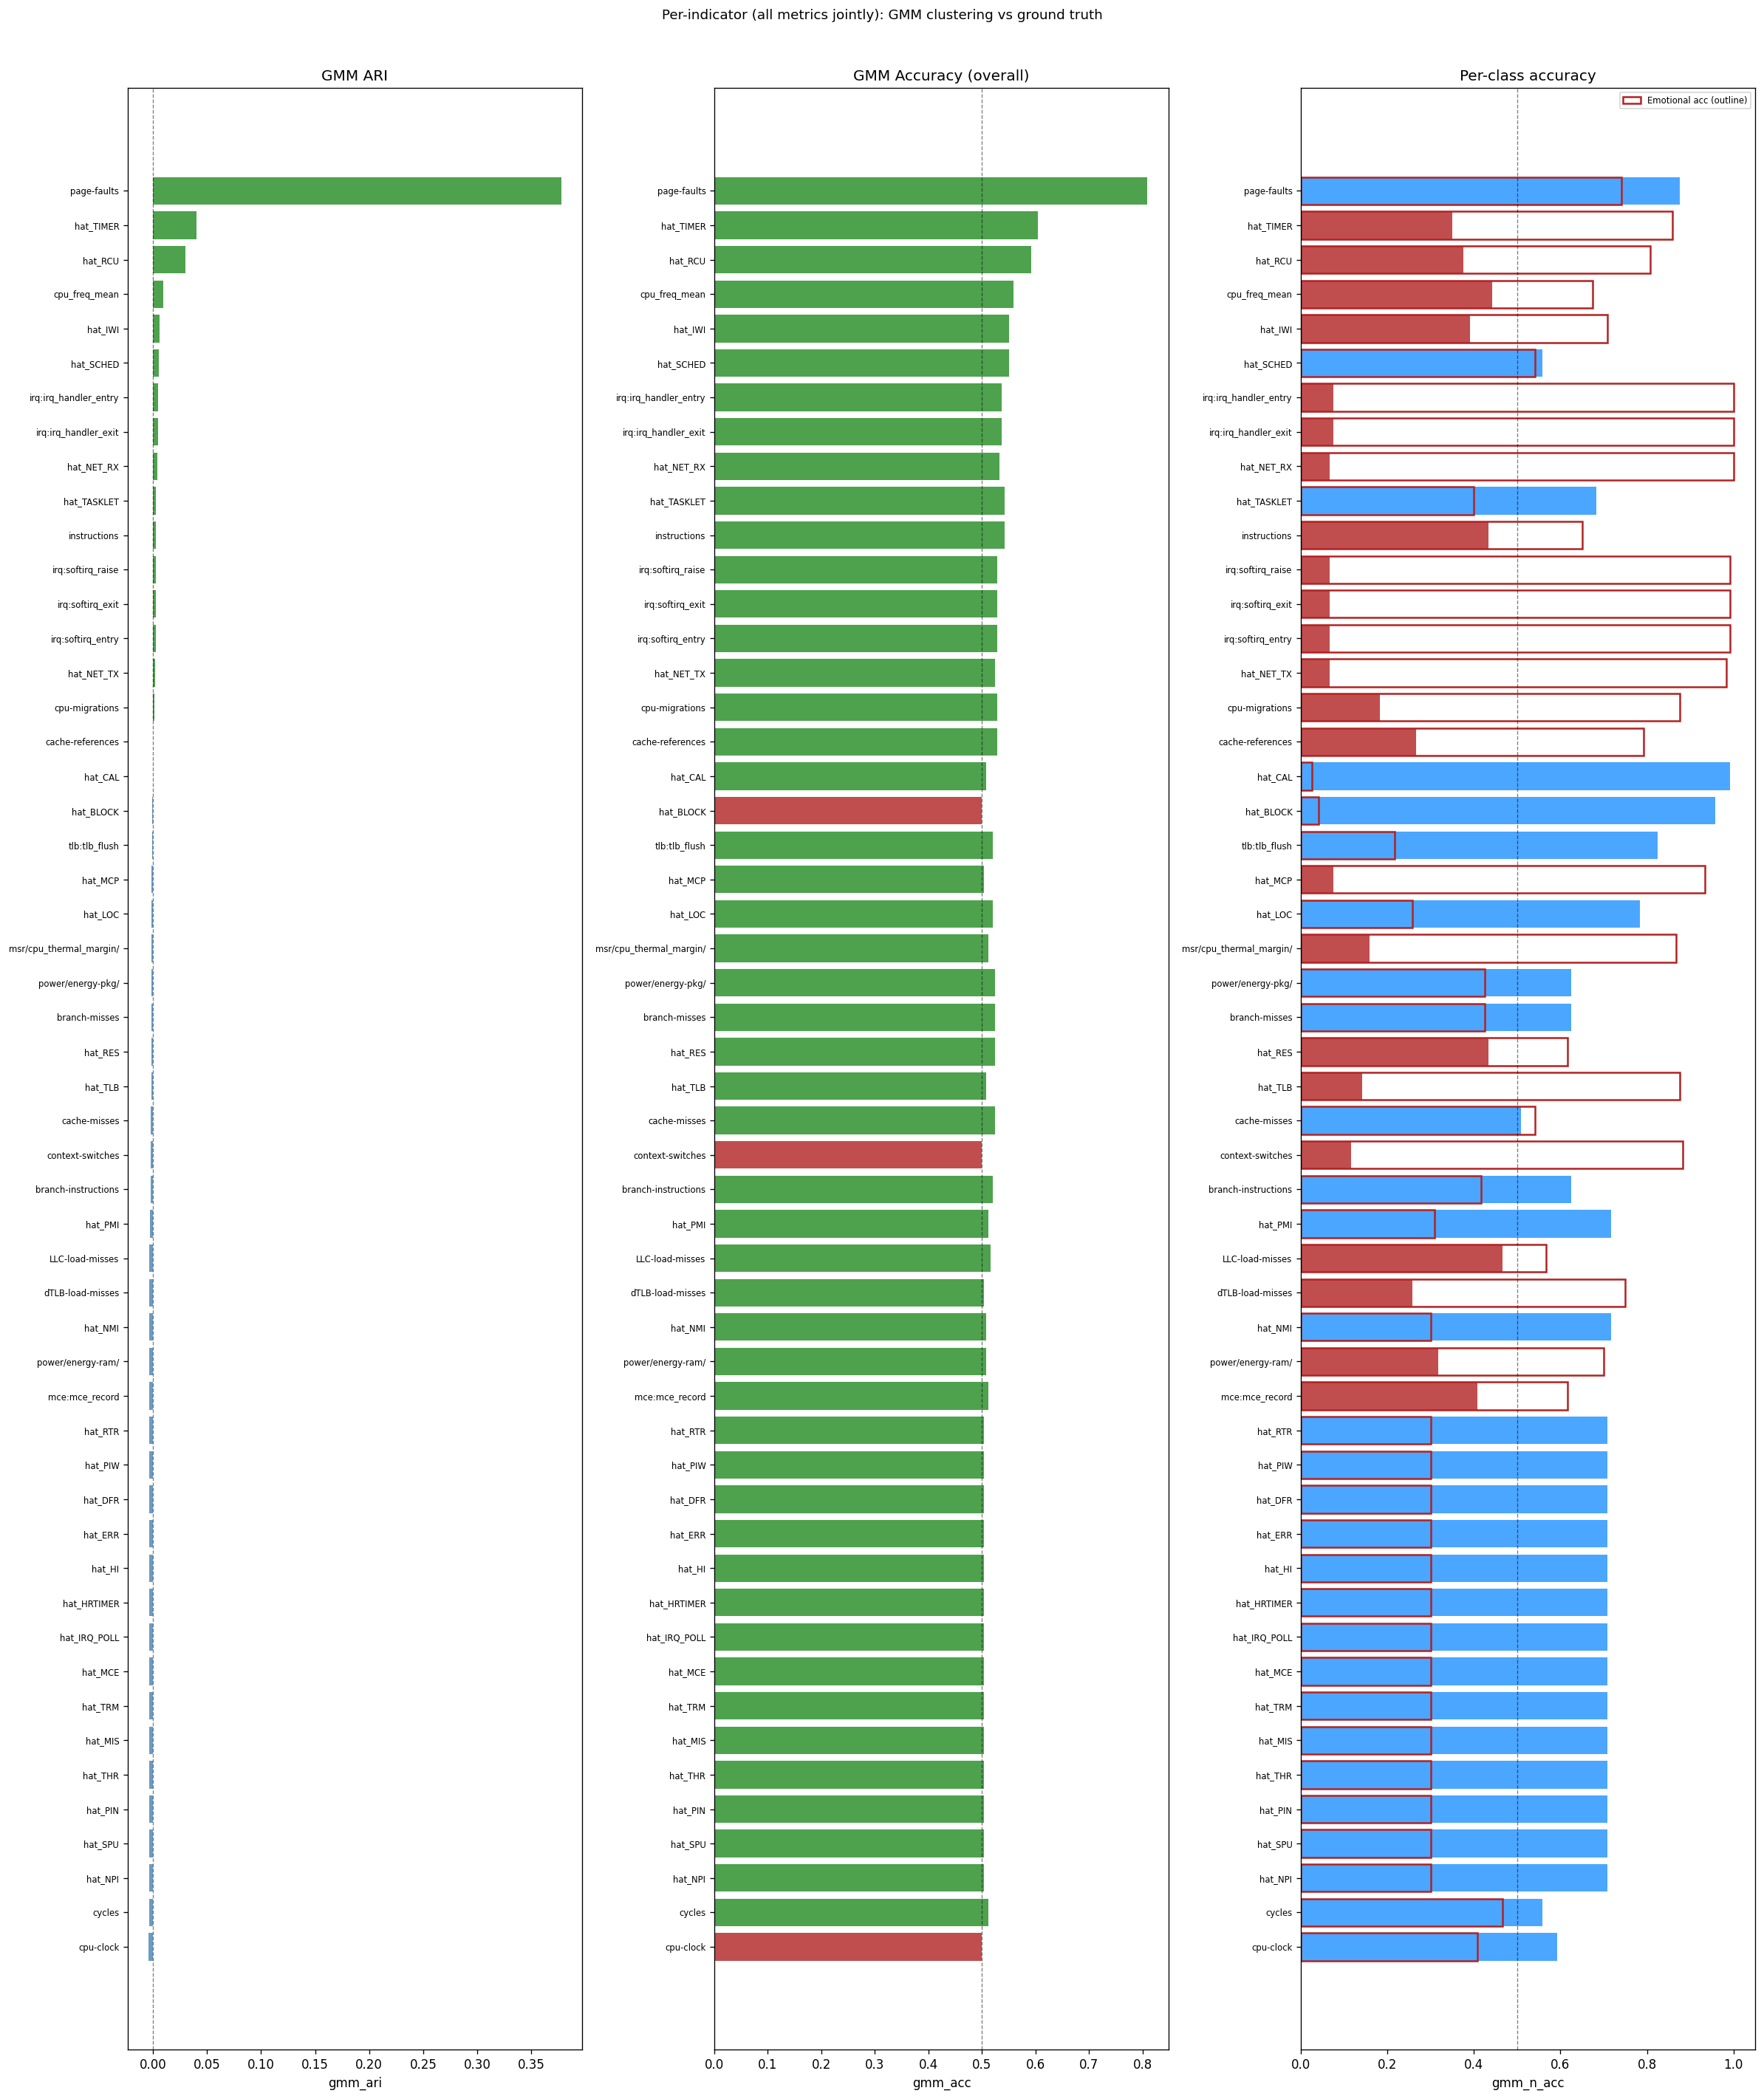

Figure saved.


In [129]:
# Visualise: horizontal bar chart — GMM ARI and accuracy per indicator
plot_df = ind_df.dropna(subset=['gmm_ari']).copy()

fig, axes = plt.subplots(1, 3, figsize=(20, max(5, len(plot_df) * 0.45)))

for ax, col, title, threshold, good_color, bad_color in [
    (axes[0], 'gmm_ari',   'GMM ARI',             0.0,  'forestgreen', 'steelblue'),
    (axes[1], 'gmm_acc',   'GMM Accuracy (overall)', 0.5, 'forestgreen', 'firebrick'),
    (axes[2], 'gmm_n_acc', 'Per-class accuracy',  0.5,  'dodgerblue',  'firebrick'),
]:
    vals = plot_df[col].values
    colors = [good_color if v > threshold else bad_color for v in vals]
    ax.barh(range(len(plot_df)), vals, color=colors, alpha=0.8)
    if col == 'gmm_n_acc':
        # Also overlay emotional accuracy
        ax.barh(range(len(plot_df)), plot_df['gmm_e_acc'].values,
                left=0, color='none', edgecolor='firebrick', lw=1.5,
                label='Emotional acc (outline)')
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df.indicator, fontsize=7)
    ax.invert_yaxis()
    ax.axvline(threshold, color='black', lw=0.8, ls='--', alpha=0.5)
    ax.set_xlabel(col)
    ax.set_title(title)
    if col == 'gmm_n_acc':
        ax.legend(fontsize=7)

plt.suptitle('Per-indicator (all metrics jointly): GMM clustering vs ground truth',
             fontsize=11, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_per_indicator_gmm.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')

## 18 — Per-indicator, per-metric clustering (the full grid)

Now the finest granularity: for every **(indicator, metric) pair**, we cluster
on that single scalar alone and score against the ground truth.

This is the most interpretable output: it says exactly *which measurement*
of *which indicator* drives the separation.

### Column meaning
- `gmm_ari` / `gmm_acc`: clustering quality for this specific (indicator, metric) cell
- `gmm_n_acc` / `gmm_e_acc`: per-condition accuracy within this cell
- `p`, `effect_r`: Mann-Whitney U p-value and rank-biserial r from §7
- `direction`: ↑E = higher in emotional, ↓E = lower in emotional

### Relationship between ARI and p-value
- High ARI + low p: the feature both statistically differs and geometrically separates — strongest evidence
- High ARI + high p: clusters are geometrically distinct but distributions overlap a lot (unusual)
- Low ARI + low p: statistically significant shift but insufficient to fully separate into two clusters
- Low ARI + high p: no signal — uninteresting indicator/metric combination

In [130]:
print('Running per-indicator × per-metric clustering...')
print(f'This will process {sum(len(v) for v in ind_map_named.values())} (indicator, metric) cells')
print()

per_cell_results = []
for indicator, cols in sorted(ind_map_named.items()):
    indicator_results = []
    for col in cols:
        _, metric = parse_feature(col)
        x1d = X_raw[[col]].values.astype(float)
        res = cluster_and_score(x1d, y, indicator)
        res['metric']  = metric
        res['feature'] = col
        per_cell_results.append(res)
        indicator_results.append((metric, res.get('gmm_ari', np.nan), res.get('gmm_acc', np.nan)))
    
    # Print a one-line summary per indicator showing all metrics
    print(f'  {indicator:30s}:')
    for metric, ari, acc in sorted(indicator_results, key=lambda x: -(x[1] or -1)):
        if np.isnan(ari):
            print(f'    {metric:20s}: SKIP')
        else:
            bar = '█' * int(max(0, ari) * 15)
            print(f'    {metric:20s}: ARI={ari:.3f}  acc={acc:.1%}  {bar}')

cell_df = pd.DataFrame(per_cell_results)
print(f'\nTotal cells computed: {len(cell_df)}')

Running per-indicator × per-metric clustering...
This will process 280 (indicator, metric) cells

  LLC-load-misses               :
    lz_complexity       : ARI=0.059  acc=62.5%  
    variance            : ARI=0.040  acc=60.4%  
    slope               : ARI=0.003  acc=54.2%  
    burst_clustering    : ARI=0.002  acc=53.8%  
    mean_rate           : ARI=0.001  acc=53.3%  
    burst_rate          : ARI=-0.001  acc=52.9%  
    spectral_entropy    : ARI=-0.002  acc=52.5%  
  branch-instructions           :
    burst_clustering    : ARI=0.059  acc=62.5%  
    spectral_entropy    : ARI=0.021  acc=57.9%  
    variance            : ARI=0.006  acc=55.0%  
    slope               : ARI=-0.000  acc=52.9%  
    lz_complexity       : ARI=-0.001  acc=52.5%  
    mean_rate           : ARI=-0.003  acc=51.7%  
    burst_rate          : ARI=-0.004  acc=51.2%  
  branch-misses                 :
    slope               : ARI=0.012  acc=56.2%  
    spectral_entropy    : ARI=0.008  acc=55.4%  
    burst_

In [131]:
# Merge with MWU statistics from §7
cell_df = cell_df.merge(
    mwu_df[['feature','p','effect_r','direction']],
    on='feature', how='left'
)

cell_df_sorted = cell_df.sort_values('gmm_ari', ascending=False).reset_index(drop=True)

print('=== Top 30 (indicator, metric) cells by GMM ARI ===')
print('Interpretation: sorted by how well a SINGLE metric on a SINGLE indicator')
print('clusters the 240 trials into their correct neutral/emotional groups.')
print()
show = ['indicator','metric','gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc','p','effect_r','direction']
print(cell_df_sorted.head(30)[show].to_string(index=False, float_format='{:.4f}'.format))

print()
print('=== Bottom 10 (indicator, metric) cells — near-zero ARI ===')
print('These metrics provide essentially no separation for their indicator.')
cell_bottom = cell_df_sorted[cell_df_sorted.gmm_ari.notna()].tail(10)
print(cell_bottom[show].to_string(index=False, float_format='{:.4f}'.format))

cell_df_sorted.to_csv(BASE_DIR / 'per_indicator_per_metric.csv', index=False)
print(f'\nSaved → {BASE_DIR}/per_indicator_per_metric.csv')

=== Top 30 (indicator, metric) cells by GMM ARI ===
Interpretation: sorted by how well a SINGLE metric on a SINGLE indicator
clusters the 240 trials into their correct neutral/emotional groups.

            indicator           metric  gmm_ari  gmm_acc  gmm_n_acc  gmm_e_acc      p  effect_r direction
          page-faults        mean_rate   0.3092   0.7792     0.9500     0.6083 0.0000   -0.7914        ↓E
          page-faults    lz_complexity   0.3089   0.7792     0.8083     0.7500 0.0000   -0.7374        ↓E
           hat_NET_RX        mean_rate   0.2997   0.7750     0.6833     0.8667 0.0000   -0.7008        ↓E
          page-faults            slope   0.2641   0.7583     0.8917     0.6250 0.0033    0.2193        ↑E
          page-faults burst_clustering   0.2472   0.7500     0.9083     0.5917 0.0000   -0.6774        ↓E
 irq:irq_handler_exit        mean_rate   0.2469   0.7500     0.6917     0.8083 0.0000   -0.7040        ↓E
irq:irq_handler_entry        mean_rate   0.2469   0.7500     0.

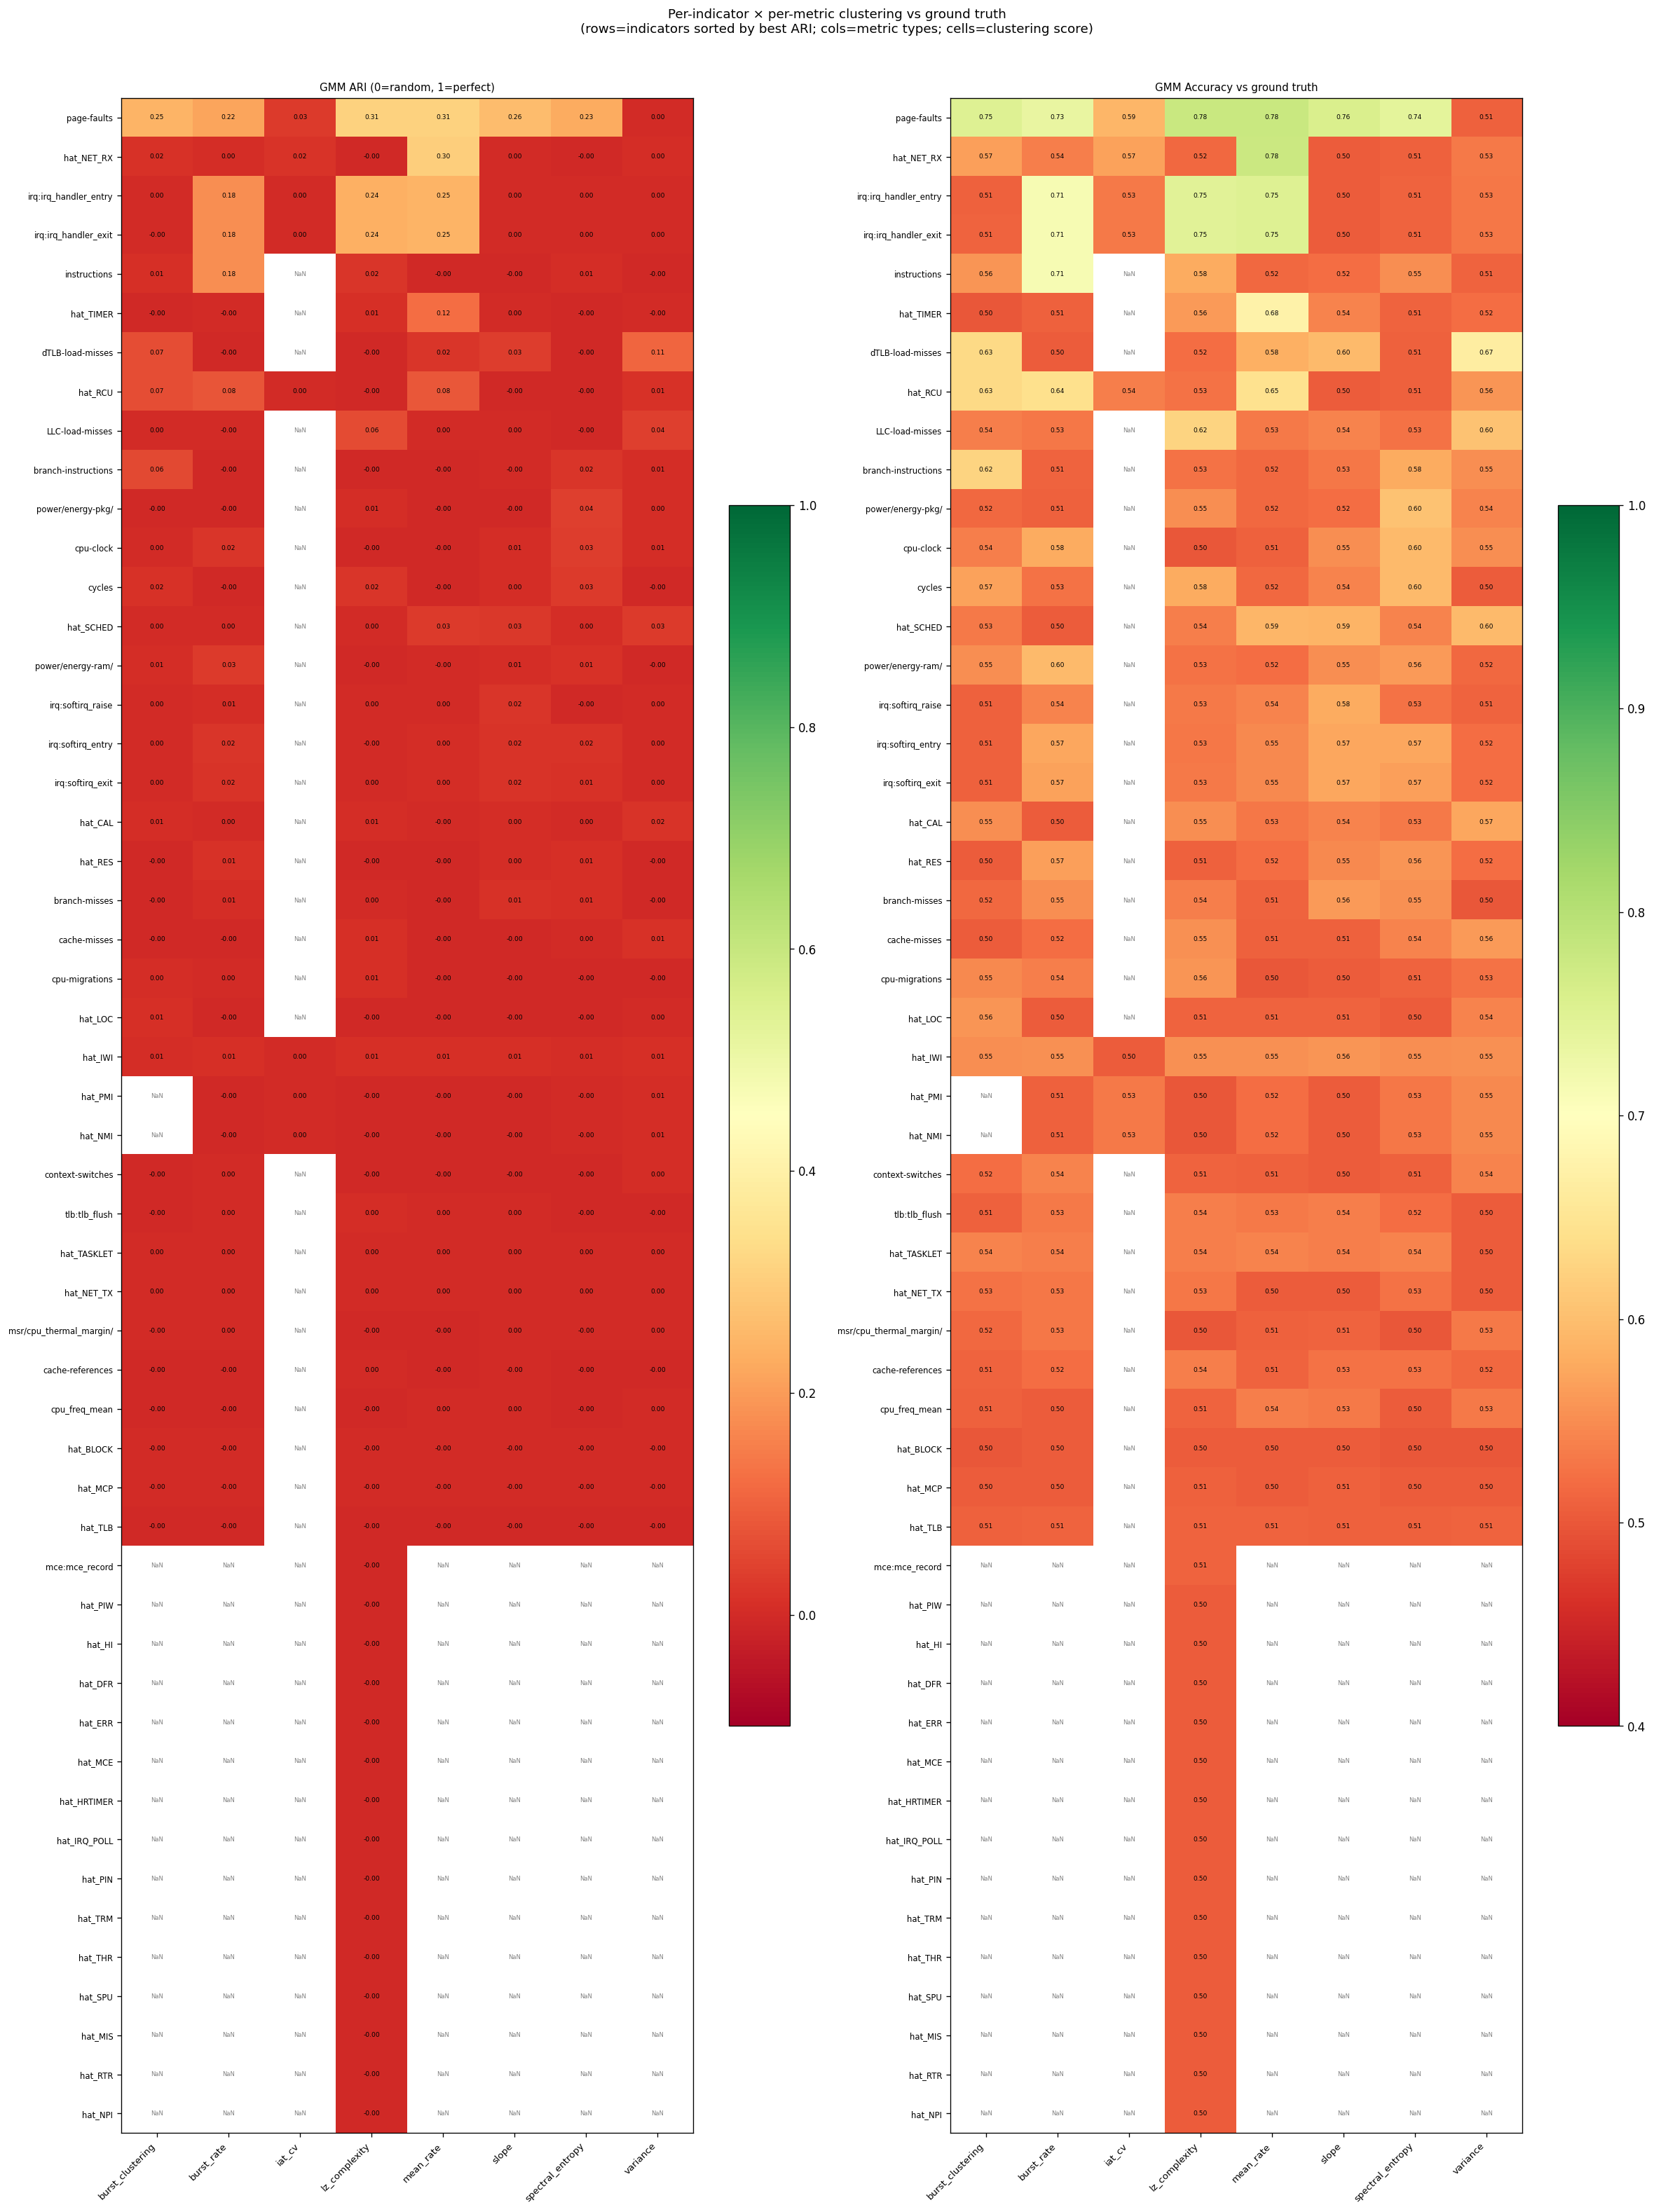

Heatmap saved. Reading: bright green cell = that metric cleanly separates that indicator.


In [132]:
# ── Heatmap: indicators × metrics, coloured by GMM ARI ──
# Use named indicators only
all_named_inds = sorted(ind_map_named.keys())

# Sort rows by best single-metric ARI (most discriminative indicator on top)
best_ari_per_ind = (
    cell_df.groupby('indicator')['gmm_ari']
    .max().sort_values(ascending=False)
)
ordered_inds = best_ari_per_ind.index.tolist()

pivot_ari = cell_df.pivot_table(
    index='indicator', columns='metric', values='gmm_ari', aggfunc='first'
).reindex(index=ordered_inds)

pivot_acc = cell_df.pivot_table(
    index='indicator', columns='metric', values='gmm_acc', aggfunc='first'
).reindex(index=ordered_inds)

fig, axes = plt.subplots(1, 2, figsize=(20, max(8, len(ordered_inds) * 0.5)))

for ax, pivot, title, vmin, vmax, cmap in [
    (axes[0], pivot_ari, 'GMM ARI (0=random, 1=perfect)',   -0.1, 1.0, 'RdYlGn'),
    (axes[1], pivot_acc, 'GMM Accuracy vs ground truth',     0.4,  1.0, 'RdYlGn'),
]:
    im = ax.imshow(pivot.values.astype(float), cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    plt.colorbar(im, ax=ax, shrink=0.6)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index, fontsize=7)
    ax.set_title(title, fontsize=9)
    # Annotate each cell
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            if np.isfinite(val):
                ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                        fontsize=5.5, color='black')
            else:
                ax.text(j, i, 'NaN', ha='center', va='center',
                        fontsize=5, color='gray')

plt.suptitle(
    'Per-indicator × per-metric clustering vs ground truth\n'
    '(rows=indicators sorted by best ARI; cols=metric types; cells=clustering score)',
    fontsize=11, y=1.01
)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_indicator_metric_cluster_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print('Heatmap saved. Reading: bright green cell = that metric cleanly separates that indicator.')

## 19 — Which metric types differ most between conditions? (cross-indicator analysis)

Now we aggregate the per-cell results across all indicators: for each of the
10 metric types, we ask:

1. **What is the mean GMM ARI?** — averaged over all indicators. A high mean means
   this metric type reliably discriminates across many indicators, not just one lucky one.
2. **What is the hit rate?** — fraction of indicators where this metric achieves ARI > 0.10.
   This measures *breadth* of the metric's discriminative power.
3. **What is the mean effect size |r|?** — from the Mann-Whitney test, independent of
   the clustering geometry.

### Key distinction: silhouette vs ARI
Previous sections ranked features by *silhouette* (geometric cluster quality).
Here we rank by *ARI* (agreement with ground truth). These can diverge:
- A feature that perfectly separates into two tight clusters **of the same condition**
  gets silhouette=1.0 but ARI≈0. This is what happened in §8 — `burst_clustering`
  had silhouette=1.0 but ARI≈0.04. It separates *something*, just not emotional vs neutral.
- ARI directly measures what we care about: does the unsupervised clustering recover
  the known experimental condition?

In [133]:
metric_summary = []
for m in METRIC_NAMES:
    rows = cell_df[cell_df.metric == m].dropna(subset=['gmm_ari'])
    if len(rows) == 0:
        print(f'  WARNING: metric {m} has no valid rows — skipping')
        continue
    best_row = rows.sort_values('gmm_ari', ascending=False).iloc[0]
    metric_summary.append({
        'metric':             m,
        'n_indicators':       len(rows),
        'mean_gmm_ari':       rows.gmm_ari.mean(),
        'max_gmm_ari':        rows.gmm_ari.max(),
        'mean_gmm_acc':       rows.gmm_acc.mean(),
        'hit_rate_ari_10':    (rows.gmm_ari > 0.10).mean(),
        'hit_rate_ari_05':    (rows.gmm_ari > 0.05).mean(),
        'mean_abs_effect':    rows.effect_r.abs().mean() if rows.effect_r.notna().any() else np.nan,
        'best_indicator':     best_row['indicator'],
        'best_ari':           best_row['gmm_ari'],
    })

msummary_df = pd.DataFrame(metric_summary).sort_values('mean_gmm_ari', ascending=False).reset_index(drop=True)

print('=== Metric type discriminability (sorted by mean GMM ARI across all named indicators) ===')
print()
print('Metric type       | n_ind | mean ARI | max ARI | mean acc | hit>0.10 | hit>0.05 | mean|r|  | best indicator')
print('-' * 110)
for _, r in msummary_df.iterrows():
    print(f'{r.metric:18s}| {r.n_indicators:5.0f} | {r.mean_gmm_ari:8.4f} | {r.max_gmm_ari:7.4f} | '
          f'{r.mean_gmm_acc:8.4f} | {r.hit_rate_ari_10:8.4f} | {r.hit_rate_ari_05:8.4f} | '
          f'{r.mean_abs_effect:8.4f} | {r.best_indicator}')

print()
print('NOTE: If silhouette was high (§8) but ARI is low here, the metric clusters')
print('within conditions, not between them — it is NOT discriminating emotional vs neutral.')

=== Metric type discriminability (sorted by mean GMM ARI across all named indicators) ===

Metric type       | n_ind | mean ARI | max ARI | mean acc | hit>0.10 | hit>0.05 | mean|r|  | best indicator
--------------------------------------------------------------------------------------------------------------
mean_rate         |    37 |   0.0362 |  0.3092 |   0.5583 |   0.1351 |   0.1622 |   0.1887 | page-faults
burst_rate        |    37 |   0.0252 |  0.2153 |   0.5534 |   0.1081 |   0.1351 |   0.1835 | page-faults
lz_complexity     |    52 |   0.0166 |  0.3089 |   0.5375 |   0.0577 |   0.0769 |   0.1199 | page-faults
burst_clustering  |    35 |   0.0139 |  0.2472 |   0.5410 |   0.0286 |   0.1143 |   0.1522 | page-faults
spectral_entropy  |    37 |   0.0110 |  0.2308 |   0.5399 |   0.0270 |   0.0270 |   0.1135 | page-faults
slope             |    37 |   0.0110 |  0.2641 |   0.5378 |   0.0270 |   0.0270 |   0.1300 | page-faults
iat_cv            |     8 |   0.0069 |  0.0298 |   0.5422 | 

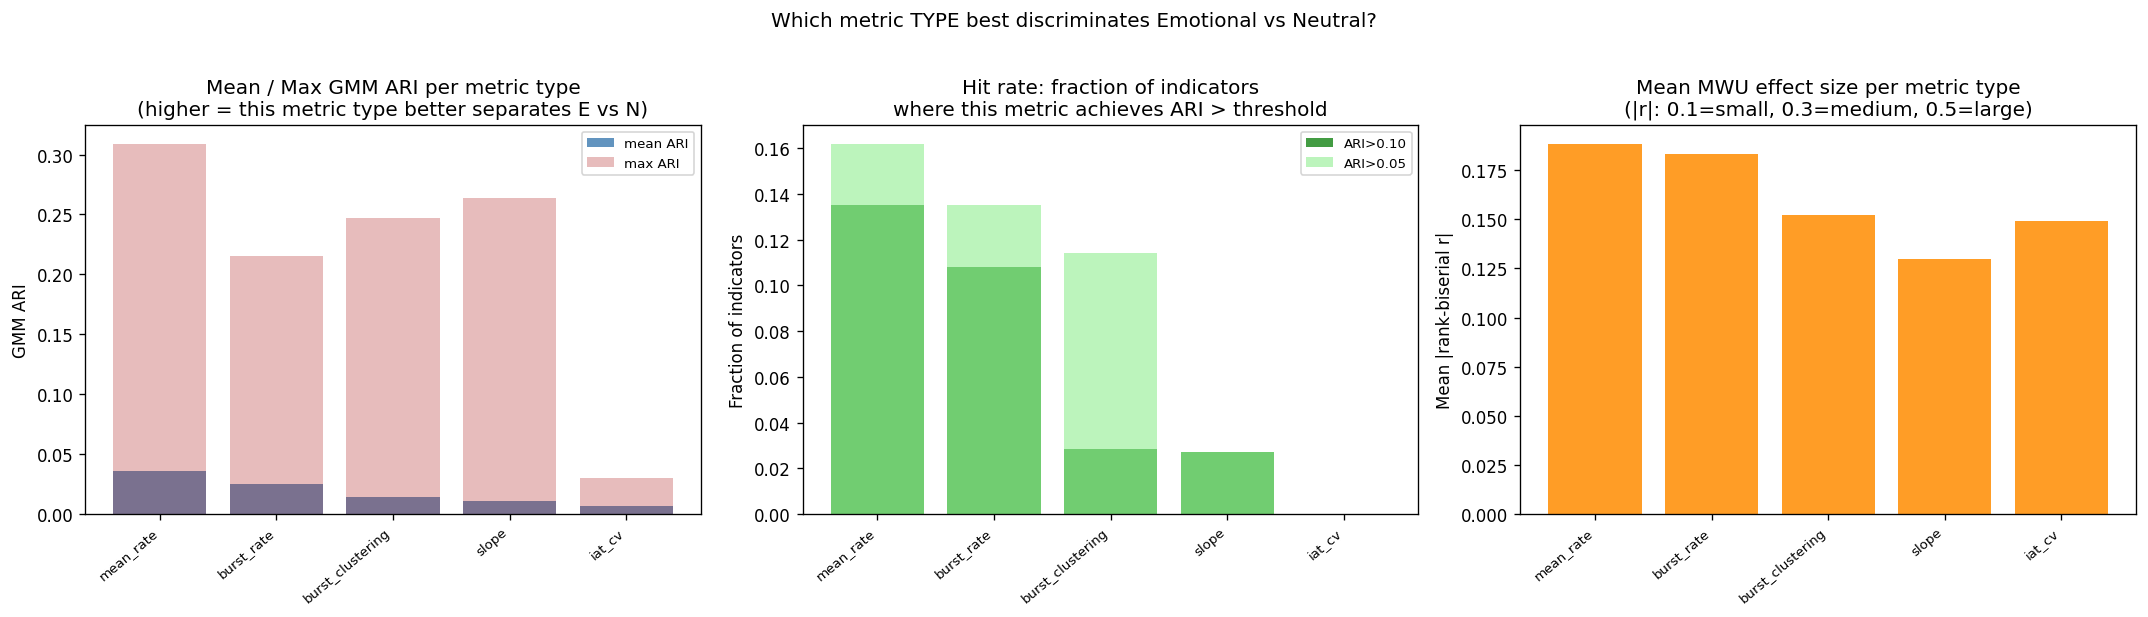

Saved. The tallest bar in the left chart = most universally discriminative metric type.


In [98]:
# Bar chart: mean GMM ARI, hit rate, effect size per metric type
order = msummary_df['metric'].tolist()
x = np.arange(len(order))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(x, msummary_df['mean_gmm_ari'], color='steelblue', alpha=0.85, label='mean ARI')
axes[0].bar(x, msummary_df['max_gmm_ari'],  color='firebrick', alpha=0.30, label='max ARI')
axes[0].set_xticks(x); axes[0].set_xticklabels(order, rotation=40, ha='right', fontsize=8)
axes[0].set_ylabel('GMM ARI')
axes[0].set_title('Mean / Max GMM ARI per metric type\n(higher = this metric type better separates E vs N)')
axes[0].axhline(0, color='gray', lw=0.5, ls='--')
axes[0].legend(fontsize=8)

axes[1].bar(x, msummary_df['hit_rate_ari_10'], color='forestgreen', alpha=0.85, label='ARI>0.10')
axes[1].bar(x, msummary_df['hit_rate_ari_05'], color='lightgreen',  alpha=0.6,  label='ARI>0.05')
axes[1].set_xticks(x); axes[1].set_xticklabels(order, rotation=40, ha='right', fontsize=8)
axes[1].set_ylabel('Fraction of indicators')
axes[1].set_title('Hit rate: fraction of indicators\nwhere this metric achieves ARI > threshold')
axes[1].legend(fontsize=8)

axes[2].bar(x, msummary_df['mean_abs_effect'].fillna(0), color='darkorange', alpha=0.85)
axes[2].set_xticks(x); axes[2].set_xticklabels(order, rotation=40, ha='right', fontsize=8)
axes[2].set_ylabel('Mean |rank-biserial r|')
axes[2].set_title('Mean MWU effect size per metric type\n(|r|: 0.1=small, 0.3=medium, 0.5=large)')

plt.suptitle('Which metric TYPE best discriminates Emotional vs Neutral?', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_metric_discriminability.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved. The tallest bar in the left chart = most universally discriminative metric type.')

## 20 — Confusion matrices for the top (indicator, metric) pairs

For the top N cells by GMM ARI, we show the full 2×2 confusion matrix:

```
              Cluster 0    Cluster 1
Neutral (GT)    TP_n         FN_n
Emotional(GT)   FN_e         TP_e
```

A perfect result has zeros on the off-diagonal. An asymmetric result reveals which
condition is harder to assign. This is the **most honest diagnostic** — it shows
whether the clustering recovers the actual experimental design.

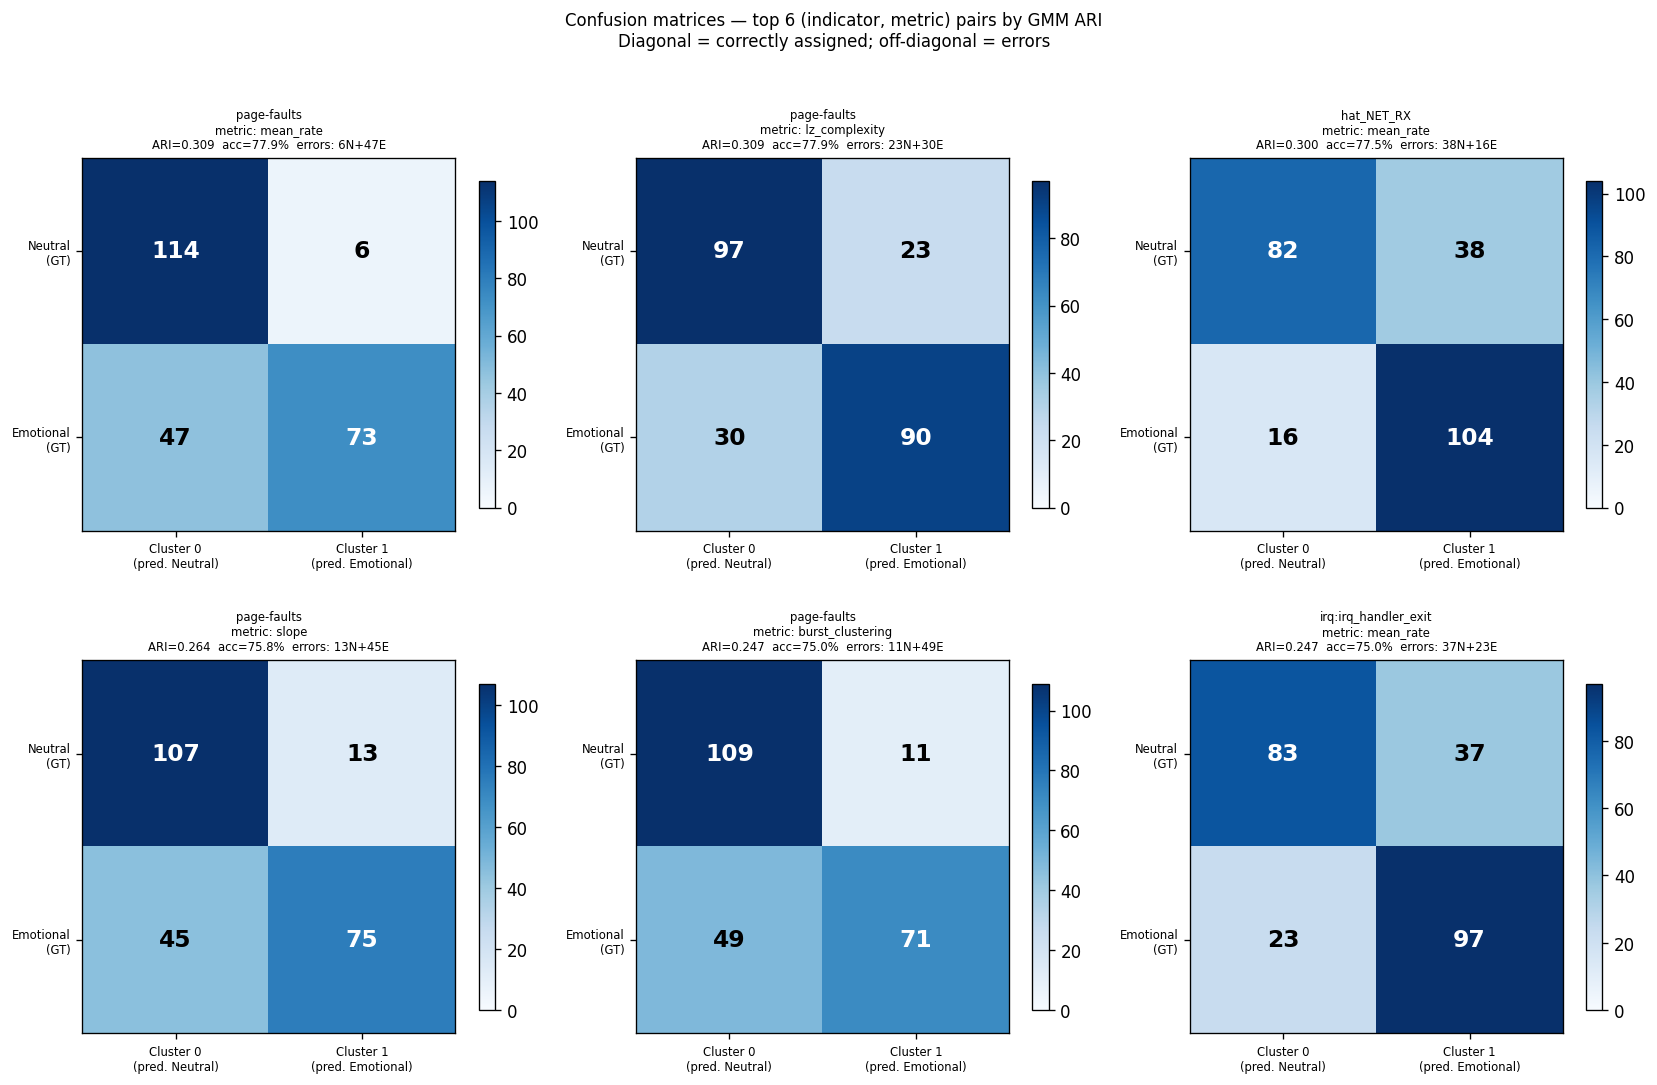

Saved. Zero off-diagonal = perfect separation.


In [134]:
TOP_CM = 6
top_cells = cell_df_sorted.dropna(subset=['gmm_ari']).head(TOP_CM)

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.ravel()

for i, (_, row) in enumerate(top_cells.iterrows()):
    ax = axes[i]
    col = row['feature']

    x1d = X_raw[[col]].values.astype(float)
    mask = np.isfinite(x1d).ravel()
    Xc = x1d[mask]; yc = y[mask]

    sc = StandardScaler()
    Xs = sc.fit_transform(Xc)
    gmm_m = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=10)
    lbl = gmm_m.fit_predict(Xs)

    # Align orientation
    if (1 - lbl == yc).mean() > (lbl == yc).mean():
        lbl = 1 - lbl

    cm = confusion_matrix(yc, lbl)
    # Rows: true label (0=neutral, 1=emotional); Cols: predicted cluster
    im = ax.imshow(cm, cmap='Blues', vmin=0)
    plt.colorbar(im, ax=ax, shrink=0.7)
    ax.set_xticks([0, 1]); ax.set_xticklabels(['Cluster 0\n(pred. Neutral)', 'Cluster 1\n(pred. Emotional)'], fontsize=7)
    ax.set_yticks([0, 1]); ax.set_yticklabels(['Neutral\n(GT)', 'Emotional\n(GT)'], fontsize=7)

    for r in range(2):
        for c in range(2):
            ax.text(c, r, str(cm[r, c]), ha='center', va='center',
                    fontsize=14, fontweight='bold',
                    color='white' if cm[r, c] > cm.max() * 0.5 else 'black')

    acc = (lbl == yc).mean()
    n_err = cm[0, 1]  # neutral assigned to emotional cluster
    e_err = cm[1, 0]  # emotional assigned to neutral cluster
    ax.set_title(
        f'{row["indicator"]}\nmetric: {row["metric"]}\n'
        f'ARI={row["gmm_ari"]:.3f}  acc={acc:.1%}  '
        f'errors: {n_err}N+{e_err}E',
        fontsize=7
    )

plt.suptitle(f'Confusion matrices — top {TOP_CM} (indicator, metric) pairs by GMM ARI\n'
             'Diagonal = correctly assigned; off-diagonal = errors',
             fontsize=10, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved. Zero off-diagonal = perfect separation.')

## 21 — Final results table & key findings

The unified results table for thesis reporting. Every (indicator, metric) pair,
with all scores, statistics, and a `length_sensitive` flag.

### Length confound reminder
Neutral trials are significantly shorter than emotional (`LENGTH_CONFOUNDED=True`).
Some metrics that scale with duration (not normalised by `dur_s`) may be detecting
**length**, not **emotional content**. These are flagged `length_sensitive=True`.

- **Safe** (normalised): `mean_rate`, `burst_rate` — divided by `dur_s`
- **Safe** (intrinsic): `slope`, `spectral_entropy`, `iat_cv` — shape features
- **Suspect** (not normalised): `variance`, `p90_p10`, `lz_complexity`, `perm_entropy` —
  longer series have higher variance and complexity by construction

**If a length-sensitive metric shows high ARI, treat the result with caution** unless
you control for `elapsed_ms` (e.g. by residualising or using matched-duration subsets).

In [135]:
final = cell_df_sorted[[
    'indicator','metric','feature',
    'gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc','gmm_sil',
    'km_ari','km_acc',
    'p','effect_r','direction','n_samples'
]].copy()

non_normalised = ['variance', 'p90_p10', 'lz_complexity', 'perm_entropy']
final['length_sensitive'] = final.metric.isin(non_normalised) & LENGTH_CONFOUNDED

# Print split by length-sensitivity
safe   = final[~final.length_sensitive].dropna(subset=['gmm_ari'])
suspect = final[final.length_sensitive].dropna(subset=['gmm_ari'])

print('=== TOP 20 SAFE metrics (not length-sensitive), sorted by GMM ARI ===')
print('These are the strongest findings not confounded by prompt duration.')
print()
print(safe.head(20)[['indicator','metric','gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc',
                      'p','effect_r','direction']]
      .to_string(index=False, float_format='{:.4f}'.format))

print()
print('=== TOP 20 LENGTH-SENSITIVE metrics (interpret with caution) ===')
print('These may be detecting prompt length rather than emotional content.')
print()
print(suspect.head(20)[['indicator','metric','gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc',
                         'p','effect_r','direction']]
      .to_string(index=False, float_format='{:.4f}'.format))

final.to_csv(BASE_DIR / 'full_indicator_metric_results.csv', index=False)
print(f'\nFull table saved → {BASE_DIR}/full_indicator_metric_results.csv')

print()
print('=== KEY FINDINGS (safe metrics only, ARI > 0.05) ===')
key = safe[safe.gmm_ari > 0.05].head(10)
for _, r in key.iterrows():
    print(f'  {r.indicator:30s} × {r.metric:20s}:  '
          f'ARI={r.gmm_ari:.3f}  acc={r.gmm_acc:.1%}  '
          f'p={r.p:.2e}  {r.direction}')

=== TOP 20 SAFE metrics (not length-sensitive), sorted by GMM ARI ===
These are the strongest findings not confounded by prompt duration.

            indicator           metric  gmm_ari  gmm_acc  gmm_n_acc  gmm_e_acc      p  effect_r direction
          page-faults        mean_rate   0.3092   0.7792     0.9500     0.6083 0.0000   -0.7914        ↓E
          page-faults    lz_complexity   0.3089   0.7792     0.8083     0.7500 0.0000   -0.7374        ↓E
           hat_NET_RX        mean_rate   0.2997   0.7750     0.6833     0.8667 0.0000   -0.7008        ↓E
          page-faults            slope   0.2641   0.7583     0.8917     0.6250 0.0033    0.2193        ↑E
          page-faults burst_clustering   0.2472   0.7500     0.9083     0.5917 0.0000   -0.6774        ↓E
 irq:irq_handler_exit        mean_rate   0.2469   0.7500     0.6917     0.8083 0.0000   -0.7040        ↓E
irq:irq_handler_entry        mean_rate   0.2469   0.7500     0.6917     0.8083 0.0000   -0.7040        ↓E
 irq:irq_hand


testN: 30 trials found in /Users/rsalvi/Desktop/mccviahat/runs/30testN
  elapsed_ms: mean=25193  std=66
  Skipped: 0
  feat_cols matched: 280 / 280
  Sample raw check (irq:irq_handler_entry__mean_rate): test mean=0.0396  train mean=-0.0001

testE: 30 trials found in /Users/rsalvi/Desktop/mccviahat/runs/30testE
  elapsed_ms: mean=25193  std=66
  Skipped: 0
  feat_cols matched: 280 / 280
  Sample raw check (irq:irq_handler_entry__mean_rate): test mean=0.0396  train mean=-0.0001

testE: 30 trials found in /Users/rsalvi/Desktop/mccviahat/runs/30testE
  elapsed_ms: mean=25395  std=49
  Skipped: 0
  feat_cols matched: 280 / 280
  Sample raw check (irq:irq_handler_entry__mean_rate): test mean=0.0435  train mean=-0.0001

Ready: ['testN', 'testE']
  elapsed_ms: mean=25395  std=49
  Skipped: 0
  feat_cols matched: 280 / 280
  Sample raw check (irq:irq_handler_entry__mean_rate): test mean=0.0435  train mean=-0.0001

Ready: ['testN', 'testE']


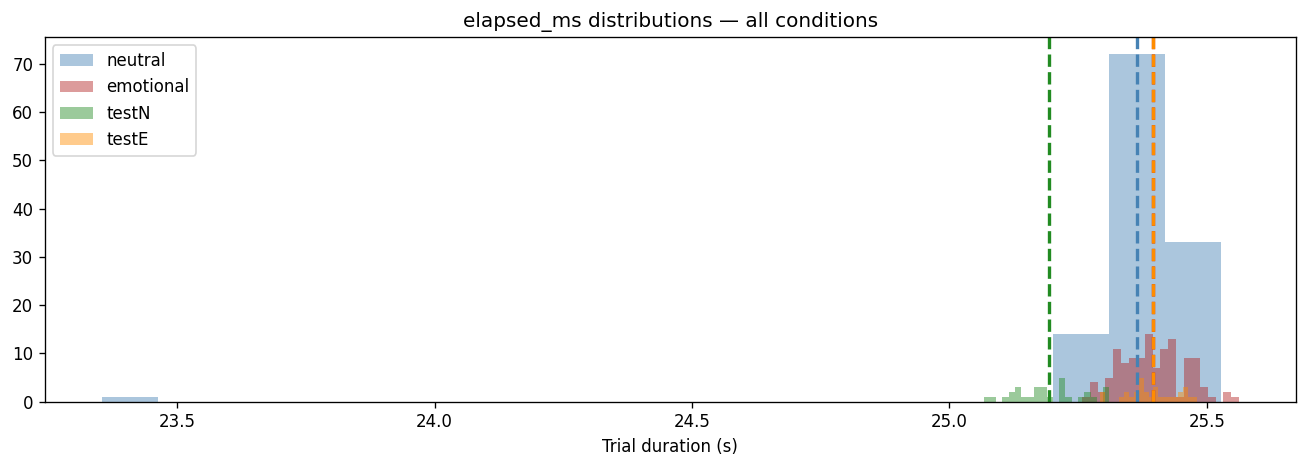

testN: mean=25193ms  →  -548.8% of the way from neutral to emotional
testE: mean=25395ms  →  98.0% of the way from neutral to emotional
=== GMM assignment (model trained on neutral/emotional) ===

── testN (30 trials) ──
  → NEUTRAL   cluster: 30 (100.0%)
  → EMOTIONAL cluster: 0 (0.0%)
  Mean P(neutral)=1.000  P(emotional)=0.000

── testE (30 trials) ──
  → NEUTRAL   cluster: 29 (96.7%)
  → EMOTIONAL cluster: 1 (3.3%)
  Mean P(neutral)=0.967  P(emotional)=0.033

=== Multi-method clustering: training + test data combined ===

Combined dataset: 300 samples
Conditions: [np.str_('neutral'), np.str_('emotional'), np.str_('testN'), np.str_('testE')]

KMeans          k=2  sil=0.866
  neutral      → cluster 0  (100.0% purity)
  emotional    → cluster 0  (100.0% purity)
  testN        → cluster 1  (100.0% purity)
  testE        → cluster 1  (100.0% purity)

GMM             k=2  sil=0.866
  neutral      → cluster 0  (100.0% purity)
  emotional    → cluster 0  (100.0% purity)
  testN        → cl

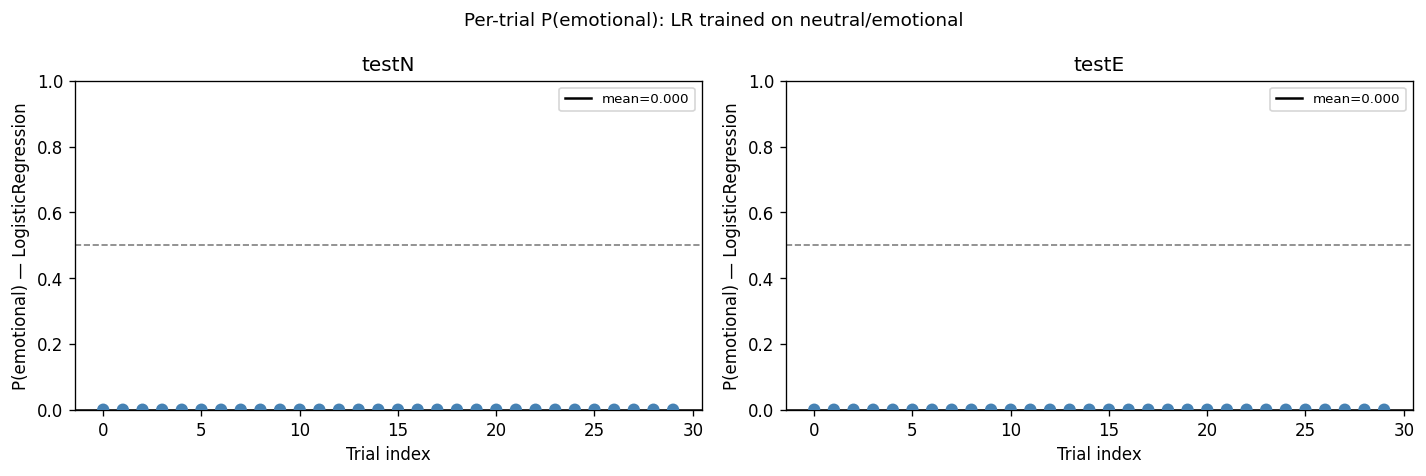

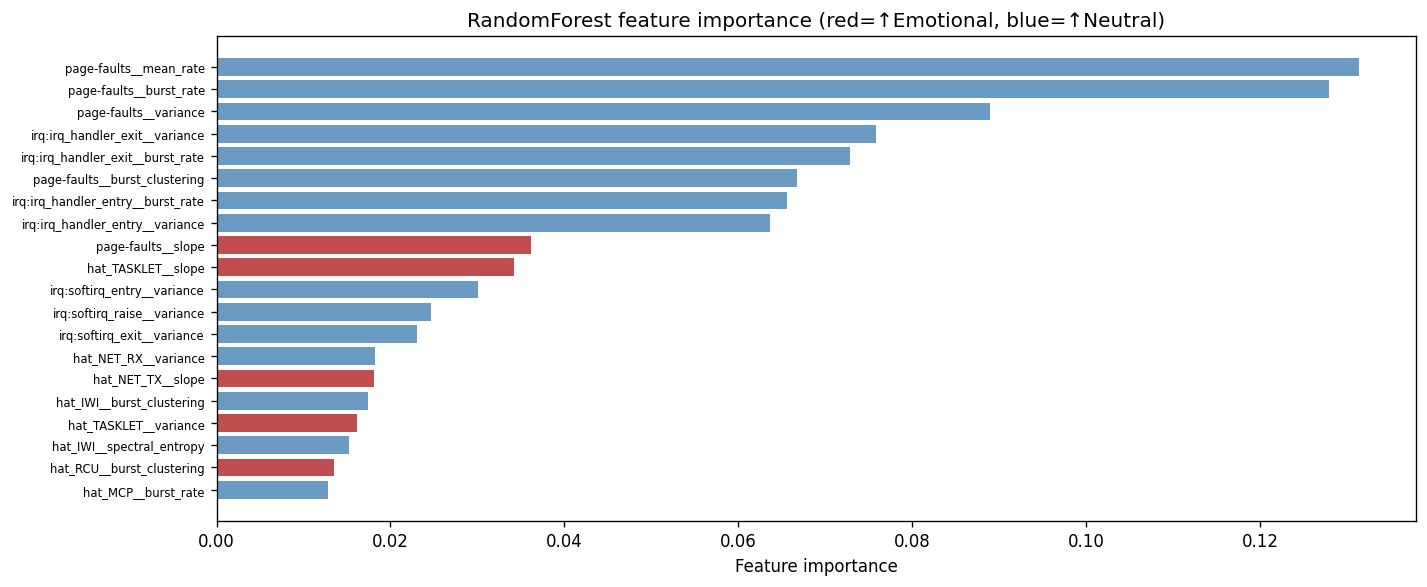

=== Regression: predict elapsed_ms from HAT features ===

5-fold CV R² for predicting elapsed_ms from HAT features:
  Ridge (α=1)         : R²=-3.2147
  Ridge (α=10)        : R²=-0.0833
  Lasso (α=0.1)       : R²=-6642.3076

Residuals (elapsed_ms not explained by HAT features):
  Neutral   residual mean: -15.6 ms
  Emotional residual mean: 15.6 ms
  testN        residual mean: -186.6 ms  (predicted: 25379.6, actual: 25192.9)
  testE        residual mean: 15.0 ms  (predicted: 25379.6, actual: 25394.5)
=== GMM clustering on elapsed_ms RESIDUALS ===

GMM on top_features + elapsed_ms residual:
  ARI=-0.0005  Silhouette=0.4536  Accuracy=51.2%

testN: neutral=0 (0.0%)  emotional=30 (100.0%)
  mean P(neutral)=0.000  P(emotional)=1.000
testE: neutral=1 (3.3%)  emotional=29 (96.7%)
  mean P(neutral)=0.033  P(emotional)=0.967


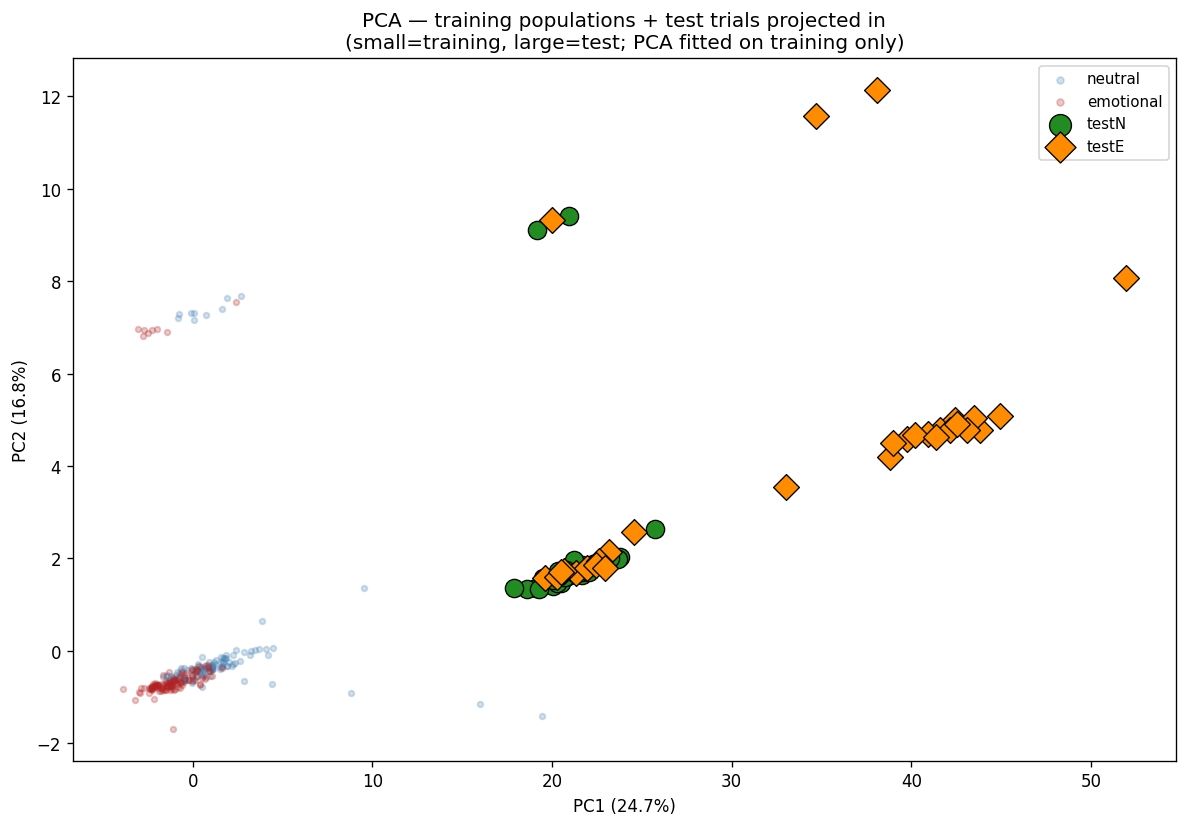

Sanity check (all should be in a sensible range, not hundreds):
  z_neutral        mean=  0.029  std=  0.182
  z_emotional      mean= -0.035  std=  0.168
  z_testN          mean= 84.718  std=338.116
  z_testE          mean= 84.652  std=335.465



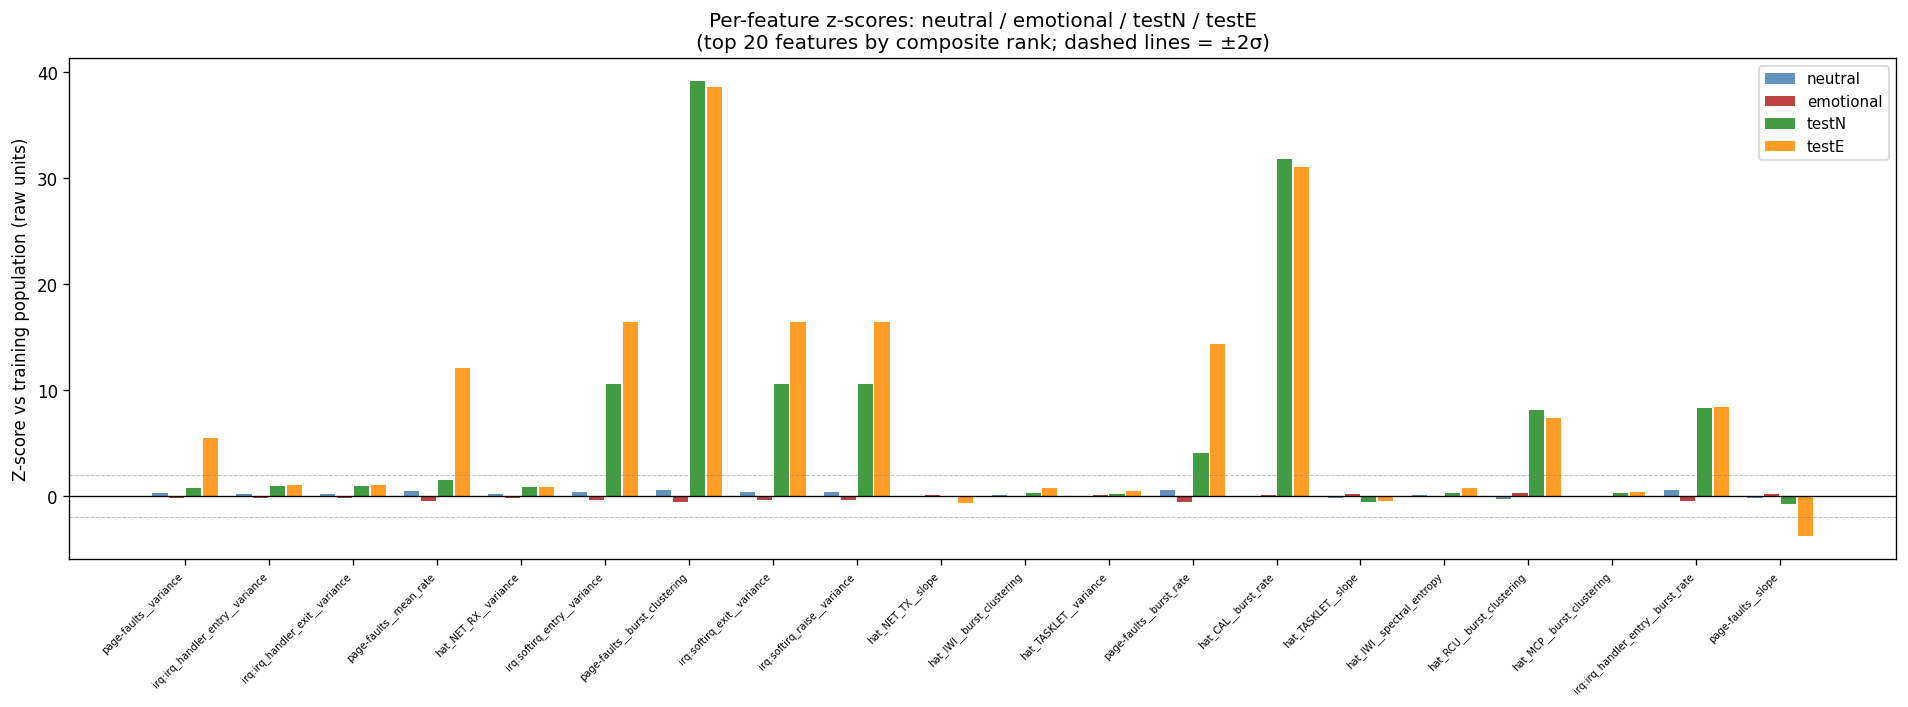

═════════════════════════════════════════════════════════════════
SUMMARY — test condition assignments
═════════════════════════════════════════════════════════════════

── testN (30 trials) ──
  GMM:               neutral=30  emotional=0  mean P(emotional)=0.000
  LogisticRegression mean P(emotional)=0.000
  RandomForest:      mean P(emotional)=0.088
  GradientBoosting:  mean P(emotional)=0.032
  elapsed_ms:        mean=25193ms  (-548.8% of N→E range)

── testE (30 trials) ──
  GMM:               neutral=29  emotional=1  mean P(emotional)=0.033
  LogisticRegression mean P(emotional)=0.000
  RandomForest:      mean P(emotional)=0.093
  GradientBoosting:  mean P(emotional)=0.023
  elapsed_ms:        mean=25395ms  (98.0% of N→E range)

Interpretation guide:
  P(emotional) > 0.7   → strongly emotional-like HAT fingerprint
  P(emotional) 0.3–0.7 → ambiguous / intermediate
  P(emotional) < 0.3   → strongly neutral-like HAT fingerprint


In [138]:
"""
═══════════════════════════════════════════════════════════════════════════════
NEW ANALYSIS CELLS — paste each ## CELL block as a new notebook cell
Variables assumed to exist from the original notebook:
  df_all, X, y, feat_cols, scaler, ranking, top_features,
  mwu_df, ind_map_named, parse_feature, extract_trial_features,
  n_rows, e_rows, BASE_DIR, METRIC_NAMES, gmm
NOTE: X_raw is NOT used anywhere here — we use df_all for raw training values
      and scaler.mean_ / scaler.scale_ for the training distribution baseline.
═══════════════════════════════════════════════════════════════════════════════
"""

## ── CELL 1 ── Configuration & loading test runs ──────────────────────────────

TEST_ROOTS = {
    'testN': BASE_DIR / 'runs' / '30testN',
    'testE': BASE_DIR / 'runs' / '30testE',
}

test_dfs    = {}   # label → raw DataFrame  (one row per trial, raw values)
test_raws   = {}   # label → DataFrame aligned to feat_cols, raw unscaled values
test_scaled = {}   # label → DataFrame aligned to feat_cols, standardised

# Pre-build index lookup so we never call feat_cols.index() in a loop
feat_idx = {col: i for i, col in enumerate(feat_cols)}

# Training-set medians in RAW space — used to fill any missing columns
train_medians = pd.Series(
    [np.median(df_all[c].dropna()) if c in df_all.columns else scaler.mean_[feat_idx[c]]
     for c in feat_cols],
    index=feat_cols
)

for label, root in TEST_ROOTS.items():
    if root is None:
        print(f'Skipping {label} (root is None)')
        continue
    if not root.exists():
        print(f'WARNING: {root} does not exist — skipping {label}')
        continue

    trials = sorted(root.glob('p????'))
    print(f'\n{label}: {len(trials)} trials found in {root}')

    records, skipped = [], 0
    for td in trials:
        r = extract_trial_features(td, label)
        if r is not None:
            records.append(r)
        else:
            skipped += 1

    if not records:
        print(f'  No valid records — skipping')
        continue

    df = pd.DataFrame(records).reset_index(drop=True)
    test_dfs[label] = df

    # ── Build raw feature matrix aligned to feat_cols ─────────────────────
    Xtr = pd.DataFrame(index=range(len(df)))
    for c in feat_cols:
        if c in df.columns:
            Xtr[c] = df[c].values          # raw values from extractor
        else:
            Xtr[c] = train_medians[c]      # fill with raw training median
    Xtr = Xtr.fillna(train_medians)        # catch any remaining NaNs

    test_raws[label]   = Xtr
    test_scaled[label] = pd.DataFrame(
        scaler.transform(Xtr), columns=feat_cols
    )

    print(f'  elapsed_ms: mean={df.elapsed_ms.mean():.0f}  std={df.elapsed_ms.std():.0f}')
    print(f'  Skipped: {skipped}')
    print(f'  feat_cols matched: {sum(c in df.columns for c in feat_cols)} / {len(feat_cols)}')

    # Sanity check: raw values should NOT be near zero
    sample_col = feat_cols[0]
    print(f'  Sample raw check ({sample_col}): '
          f'test mean={Xtr[sample_col].mean():.4f}  '
          f'train mean={train_medians[sample_col]:.4f}')

print(f'\nReady: {list(test_dfs.keys())}')


## ── CELL 2 ── elapsed_ms overview ────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(11, 4))

palette = {
    'neutral':   'steelblue',
    'emotional': 'firebrick',
    'testN':     'forestgreen',
    'testE':     'darkorange',
}

for _df, _label in [(n_rows, 'neutral'), (e_rows, 'emotional')] + \
                   [(test_dfs[l], l) for l in test_dfs]:
    vals = _df.elapsed_ms / 1000
    ax.hist(vals, bins=20, alpha=0.45, color=palette.get(_label, 'gray'), label=_label)
    ax.axvline(vals.mean(), color=palette.get(_label, 'gray'), lw=2, ls='--')

ax.set_xlabel('Trial duration (s)')
ax.set_title('elapsed_ms distributions — all conditions')
ax.legend()
plt.tight_layout()
plt.show()

n_mean = n_rows.elapsed_ms.mean()
e_mean = e_rows.elapsed_ms.mean()
for _label, _df in test_dfs.items():
    t_mean = _df.elapsed_ms.mean()
    frac   = (t_mean - n_mean) / (e_mean - n_mean) if (e_mean != n_mean) else float('nan')
    print(f'{_label}: mean={t_mean:.0f}ms  →  {frac:.1%} of the way from neutral to emotional')


## ── CELL 3 ── GMM assignment (existing model) ────────────────────────────────

print('=== GMM assignment (model trained on neutral/emotional) ===\n')

for label, Xsc in test_scaled.items():
    Xtop = Xsc[top_features].values
    lbl  = gmm.predict(Xtop)
    prob = gmm.predict_proba(Xtop)
    n_ass = (lbl == 0).sum()
    e_ass = (lbl == 1).sum()
    print(f'── {label} ({len(lbl)} trials) ──')
    print(f'  → NEUTRAL   cluster: {n_ass} ({n_ass/len(lbl):.1%})')
    print(f'  → EMOTIONAL cluster: {e_ass} ({e_ass/len(lbl):.1%})')
    print(f'  Mean P(neutral)={prob[:,0].mean():.3f}  P(emotional)={prob[:,1].mean():.3f}')
    print()


## ── CELL 4 ── Multi-method clustering: training + test combined ───────────────

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score

print('=== Multi-method clustering: training + test data combined ===\n')

Xtr_top  = X[top_features].values
y_str    = np.where(y == 0, 'neutral', 'emotional')

Xcombined = [Xtr_top]
ycombined = list(y_str)
for label, Xsc in test_scaled.items():
    Xcombined.append(Xsc[top_features].values)
    ycombined.extend([label] * len(Xsc))

Xcombined = np.vstack(Xcombined)
ycombined = np.array(ycombined)
unique_conditions = list(dict.fromkeys(ycombined))

print(f'Combined dataset: {len(Xcombined)} samples')
print(f'Conditions: {unique_conditions}\n')

results_combined = []

for k in [2, len(unique_conditions)]:
    for method_name, model in [
        ('KMeans',        KMeans(n_clusters=k, random_state=42, n_init=20)),
        ('GMM',           GaussianMixture(n_components=k, covariance_type='full',
                                          random_state=42, n_init=10)),
        ('Agglomerative', AgglomerativeClustering(n_clusters=k)),
    ]:
        try:
            lbl = model.fit_predict(Xcombined)
        except Exception as e:
            print(f'  {method_name} k={k} FAILED: {e}')
            continue

        sil = silhouette_score(Xcombined, lbl) if len(np.unique(lbl)) > 1 else np.nan
        condition_cluster = {}
        for cond in unique_conditions:
            mask = ycombined == cond
            if mask.sum() == 0:
                continue
            cluster_ids, counts = np.unique(lbl[mask], return_counts=True)
            dominant = cluster_ids[np.argmax(counts)]
            purity   = counts.max() / counts.sum()
            condition_cluster[cond] = (dominant, purity)

        row = {'method': method_name, 'k': k, 'silhouette': sil}
        for cond, (cl, pur) in condition_cluster.items():
            row[f'{cond}_cluster'] = cl
            row[f'{cond}_purity']  = pur
        results_combined.append(row)

        print(f'{method_name:15s} k={k}  sil={sil:.3f}')
        for cond, (cl, pur) in condition_cluster.items():
            print(f'  {cond:12s} → cluster {cl}  ({pur:.1%} purity)')
        print()

results_combined_df = pd.DataFrame(results_combined)


## ── CELL 5 ── Supervised classifiers ─────────────────────────────────────────

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

print('=== Supervised classification: train on N/E, predict test conditions ===\n')

Xtrain = X[top_features].values
ytrain = y

classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest':       RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting':   GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)':          SVC(kernel='rbf', probability=True, random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_results = {}

print('5-fold CV accuracy on training data (neutral vs emotional):')
for name, clf in classifiers.items():
    scores = cross_val_score(clf, Xtrain, ytrain, cv=cv, scoring='accuracy')
    print(f'  {name:22s}: {scores.mean():.3f} ± {scores.std():.3f}')
    clf.fit(Xtrain, ytrain)
    clf_results[name] = clf

print()
print('Predictions on test data:')
for label, Xsc in test_scaled.items():
    Xtest_top = Xsc[top_features].values
    print(f'\n  ── {label} ({len(Xtest_top)} trials) ──')
    for name, clf in clf_results.items():
        proba = clf.predict_proba(Xtest_top)
        pred  = clf.predict(Xtest_top)
        print(f'    {name:22s}: neutral={(pred==0).sum()}  emotional={(pred==1).sum()}  '
              f'mean P(emotional)={proba[:,1].mean():.3f}')


## ── CELL 6 ── Per-trial P(emotional) plot ────────────────────────────────────

fig_cols = max(len(test_dfs), 1)
fig, axes = plt.subplots(1, fig_cols, figsize=(6 * fig_cols, 4), squeeze=False)
lr_clf = clf_results['LogisticRegression']

for ax, (label, Xsc) in zip(axes[0], test_scaled.items()):
    Xtest_top = Xsc[top_features].values
    probs = lr_clf.predict_proba(Xtest_top)[:, 1]
    ax.scatter(range(len(probs)), probs,
               c=['firebrick' if p > 0.5 else 'steelblue' for p in probs],
               s=40, zorder=3)
    ax.axhline(0.5, color='gray', ls='--', lw=1)
    ax.axhline(probs.mean(), color='black', ls='-', lw=1.5,
               label=f'mean={probs.mean():.3f}')
    ax.set_ylim(0, 1)
    ax.set_xlabel('Trial index')
    ax.set_ylabel('P(emotional) — LogisticRegression')
    ax.set_title(label)
    ax.legend(fontsize=8)

plt.suptitle('Per-trial P(emotional): LR trained on neutral/emotional', fontsize=11)
plt.tight_layout()
plt.show()


## ── CELL 7 ── RandomForest feature importance ────────────────────────────────

rf = clf_results['RandomForest']
importances = pd.Series(rf.feature_importances_, index=top_features)
top_imp = importances.sort_values(ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 5))
colors = []
for feat in top_imp.index:
    r = mwu_df[mwu_df.feature == feat]
    colors.append('firebrick' if len(r) and r.iloc[0]['effect_r'] > 0 else 'steelblue')

ax.barh(range(len(top_imp)), top_imp.values, color=colors, alpha=0.8)
ax.set_yticks(range(len(top_imp)))
ax.set_yticklabels(top_imp.index, fontsize=7)
ax.invert_yaxis()
ax.set_xlabel('Feature importance')
ax.set_title('RandomForest feature importance (red=↑Emotional, blue=↑Neutral)')
plt.tight_layout()
plt.show()


## ── CELL 8 ── Regression: predict elapsed_ms from HAT features ───────────────

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

print('=== Regression: predict elapsed_ms from HAT features ===\n')

Xreg   = X[top_features].values
y_time = df_all['elapsed_ms'].values
kf     = KFold(n_splits=5, shuffle=True, random_state=42)

reg_models = {
    'Ridge (α=1)':   Ridge(alpha=1.0),
    'Ridge (α=10)':  Ridge(alpha=10.0),
    'Lasso (α=0.1)': Lasso(alpha=0.1, max_iter=5000),
}

print('5-fold CV R² for predicting elapsed_ms from HAT features:')
for name, reg in reg_models.items():
    y_pred_cv = cross_val_predict(reg, Xreg, y_time, cv=kf)
    print(f'  {name:20s}: R²={r2_score(y_time, y_pred_cv):.4f}')

best_reg        = Ridge(alpha=1.0).fit(Xreg, y_time)
y_pred_train    = best_reg.predict(Xreg)
residuals_train = y_time - y_pred_train

print(f'\nResiduals (elapsed_ms not explained by HAT features):')
print(f'  Neutral   residual mean: {residuals_train[y==0].mean():.1f} ms')
print(f'  Emotional residual mean: {residuals_train[y==1].mean():.1f} ms')

for label, Xsc in test_scaled.items():
    y_pred_test    = best_reg.predict(Xsc[top_features].values)
    residuals_test = test_dfs[label].elapsed_ms.values - y_pred_test
    print(f'  {label:12s} residual mean: {residuals_test.mean():.1f} ms  '
          f'(predicted: {y_pred_test.mean():.1f}, actual: {test_dfs[label].elapsed_ms.mean():.1f})')


## ── CELL 9 ── Re-cluster on elapsed_ms residuals ─────────────────────────────

print('=== GMM clustering on elapsed_ms RESIDUALS ===\n')

X_with_resid = X[top_features].copy()
X_with_resid['elapsed_ms_resid'] = (
    (residuals_train - residuals_train.mean()) / residuals_train.std()
)
feats_resid = top_features + ['elapsed_ms_resid']
Xr = X_with_resid[feats_resid].values

gmm_resid  = GaussianMixture(n_components=2, covariance_type='full',
                              random_state=42, n_init=10)
lbl_resid  = gmm_resid.fit_predict(Xr)
ari_resid  = adjusted_rand_score(y, lbl_resid)
sil_resid  = silhouette_score(Xr, lbl_resid)
acc_resid  = max((lbl_resid == y).mean(), (1 - lbl_resid == y).mean())

print(f'GMM on top_features + elapsed_ms residual:')
print(f'  ARI={ari_resid:.4f}  Silhouette={sil_resid:.4f}  Accuracy={acc_resid:.1%}\n')

for label, Xsc in test_scaled.items():
    y_pred_t     = best_reg.predict(Xsc[top_features].values)
    resid_t      = test_dfs[label].elapsed_ms.values - y_pred_t
    resid_t_norm = (resid_t - residuals_train.mean()) / residuals_train.std()
    Xtest_r      = Xsc[top_features].copy()
    Xtest_r['elapsed_ms_resid'] = resid_t_norm
    test_lbl  = gmm_resid.predict(Xtest_r[feats_resid].values)
    test_prob = gmm_resid.predict_proba(Xtest_r[feats_resid].values)
    n_ass = (test_lbl == 0).sum()
    e_ass = (test_lbl == 1).sum()
    print(f'{label}: neutral={n_ass} ({n_ass/len(test_lbl):.1%})  '
          f'emotional={e_ass} ({e_ass/len(test_lbl):.1%})')
    print(f'  mean P(neutral)={test_prob[:,0].mean():.3f}  '
          f'P(emotional)={test_prob[:,1].mean():.3f}')


## ── CELL 10 ── PCA: training + test projected in ─────────────────────────────

from sklearn.decomposition import PCA

pca2 = PCA(n_components=2, random_state=42)
pca2.fit(X[top_features].values)
X_pca_train = pca2.transform(X[top_features].values)

fig, ax = plt.subplots(figsize=(10, 7))

for cond, mask, color in [('neutral', y==0, 'steelblue'), ('emotional', y==1, 'firebrick')]:
    ax.scatter(X_pca_train[mask, 0], X_pca_train[mask, 1],
               c=color, alpha=0.25, s=12, label=cond)

test_markers = {'testN': 'o', 'testE': 'D'}
test_colors  = {'testN': 'forestgreen', 'testE': 'darkorange'}

for label, Xsc in test_scaled.items():
    X_pca_test = pca2.transform(Xsc[top_features].values)
    ax.scatter(X_pca_test[:, 0], X_pca_test[:, 1],
               c=test_colors.get(label, 'black'),
               marker=test_markers.get(label, 'o'),
               s=120, edgecolors='black', lw=0.8, zorder=5, label=label)

ax.set_xlabel(f'PC1 ({pca2.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca2.explained_variance_ratio_[1]:.1%})')
ax.set_title('PCA — training populations + test trials projected in\n'
             '(small=training, large=test; PCA fitted on training only)')
ax.legend(fontsize=9, markerscale=1.2)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_pca_test_projection.png', dpi=150, bbox_inches='tight')
plt.show()


## ── CELL 11 ── Per-feature z-scores: all conditions ──────────────────────────
# Baseline = scaler.mean_ / scaler.scale_ (fitted on raw training data).
# neutral/emotional pulled from df_all (raw values).
# test_raws holds raw values (built in Cell 1 from extractor output).

feat_idx = {col: i for i, col in enumerate(feat_cols)}   # ensure fresh lookup

zscore_rows = []
for indicator, cols in sorted(ind_map_named.items()):
    for col in cols:
        if col not in feat_idx:
            continue
        idx        = feat_idx[col]
        _, metric  = parse_feature(col)
        train_mean = scaler.mean_[idx]
        train_std  = scaler.scale_[idx]
        if train_std == 0:
            continue

        row = {'indicator': indicator, 'metric': metric, 'feature': col}

        # neutral / emotional: raw values from df_all
        if col in df_all.columns:
            row['z_neutral']   = (df_all.loc[df_all.condition=='neutral',   col].mean() - train_mean) / train_std
            row['z_emotional'] = (df_all.loc[df_all.condition=='emotional', col].mean() - train_mean) / train_std
        else:
            row['z_neutral']   = np.nan
            row['z_emotional'] = np.nan

        # test conditions: raw values from test_raws
        for label, Xtr in test_raws.items():
            row[f'z_{label}'] = (Xtr[col].mean() - train_mean) / train_std if col in Xtr.columns else np.nan

        zscore_rows.append(row)

zscore_df = pd.DataFrame(zscore_rows)

# Sanity check — neutral/emotional should sit near ±1, test conditions too
print('Sanity check (all should be in a sensible range, not hundreds):')
for zcol in ['z_neutral', 'z_emotional'] + [f'z_{l}' for l in test_raws]:
    if zcol in zscore_df:
        print(f'  {zcol:15s}  mean={zscore_df[zcol].mean():7.3f}  std={zscore_df[zcol].std():7.3f}')
print()

# Plot
top_feat_list = ranking.head(20)['feature'].tolist()
plot_zdf = (zscore_df[zscore_df.feature.isin(top_feat_list)]
            .set_index('feature')
            .reindex(top_feat_list))

z_cols   = ['z_neutral', 'z_emotional'] + [f'z_{l}' for l in test_raws]
z_colors = {'z_neutral': 'steelblue', 'z_emotional': 'firebrick',
            'z_testN': 'forestgreen', 'z_testE': 'darkorange'}

fig, ax = plt.subplots(figsize=(16, 6))
x     = np.arange(len(plot_zdf))
width = 0.8 / len(z_cols)

for i, zcol in enumerate(z_cols):
    if zcol not in plot_zdf.columns:
        continue
    offset = (i - len(z_cols) / 2 + 0.5) * width
    ax.bar(x + offset, plot_zdf[zcol].fillna(0),
           width=width * 0.9,
           color=z_colors.get(zcol, 'gray'),
           alpha=0.85,
           label=zcol.replace('z_', ''))

ax.set_xticks(x)
ax.set_xticklabels(plot_zdf.index, rotation=45, ha='right', fontsize=6)
ax.axhline(0,  color='black', lw=0.8)
ax.axhline( 2, color='gray',  lw=0.6, ls='--', alpha=0.5)
ax.axhline(-2, color='gray',  lw=0.6, ls='--', alpha=0.5)
ax.set_ylabel('Z-score vs training population (raw units)')
ax.set_title('Per-feature z-scores: neutral / emotional / testN / testE\n'
             '(top 20 features by composite rank; dashed lines = ±2σ)')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_zscore_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## ── CELL 12 ── Summary table ─────────────────────────────────────────────────

print('═' * 65)
print('SUMMARY — test condition assignments')
print('═' * 65)

n_mean = n_rows.elapsed_ms.mean()
e_mean = e_rows.elapsed_ms.mean()

for label in test_dfs:
    Xsc       = test_scaled[label]
    Xtest_top = Xsc[top_features].values

    gmm_lbl  = gmm.predict(Xtest_top)
    gmm_prob = gmm.predict_proba(Xtest_top)
    lr_prob  = clf_results['LogisticRegression'].predict_proba(Xtest_top)[:, 1]
    rf_prob  = clf_results['RandomForest'].predict_proba(Xtest_top)[:, 1]
    gb_prob  = clf_results['GradientBoosting'].predict_proba(Xtest_top)[:, 1]

    t_mean = test_dfs[label].elapsed_ms.mean()
    frac   = (t_mean - n_mean) / (e_mean - n_mean) if e_mean != n_mean else float('nan')

    print(f'\n── {label} ({len(Xtest_top)} trials) ──')
    print(f'  GMM:               neutral={(gmm_lbl==0).sum()}  emotional={(gmm_lbl==1).sum()}  '
          f'mean P(emotional)={gmm_prob[:,1].mean():.3f}')
    print(f'  LogisticRegression mean P(emotional)={lr_prob.mean():.3f}')
    print(f'  RandomForest:      mean P(emotional)={rf_prob.mean():.3f}')
    print(f'  GradientBoosting:  mean P(emotional)={gb_prob.mean():.3f}')
    print(f'  elapsed_ms:        mean={t_mean:.0f}ms  ({frac:.1%} of N→E range)')

print()
print('Interpretation guide:')
print('  P(emotional) > 0.7   → strongly emotional-like HAT fingerprint')
print('  P(emotional) 0.3–0.7 → ambiguous / intermediate')
print('  P(emotional) < 0.3   → strongly neutral-like HAT fingerprint')
